# Computing Statistica Properties of the EEG Data through Amplitude-Encoded Quantum Computing Inferences

This section of the code uses the work of Miriam Goldack et.al. which is used in inference experiments of statistical properties of fluid dynamics. See publication [https://arxiv.org/pdf/2601.10166](https://arxiv.org/pdf/2601.10166)


In our context, we use this approach to exctract further statistical information from the EEG dataset testing a quantum algorithmic approach.

In [246]:
import os

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from tqdm import tqdm

## Load EEG Data

In [232]:
from pathlib import Path

def list_filenames(folder_path):
    """
    Returns a list of file names (not directories) in the given folder.
    """
    folder = Path(folder_path)
    return [folder_path + p.name for p in folder.iterdir() if p.is_file()]


def get_channel_names(file_paths):
    chnames=[]
    for fpath in file_paths:
        chnames.append(fpath.split('/')[-1].split('_')[0])
    return chnames

In [234]:
patientID = 1

datapath = f'channels_for_sonification/patient{patientID}/'
file_paths = list_filenames(datapath)
channel_names = get_channel_names(file_paths)
print(file_paths)
print(channel_names)

['channels_for_sonification/patient1/TT1_no_first.txt', 'channels_for_sonification/patient1/MST4_no_first.txt', 'channels_for_sonification/patient1/TT4_no_first.txt', 'channels_for_sonification/patient1/MST2_no_first.txt', 'channels_for_sonification/patient1/AST1_no_first.txt', 'channels_for_sonification/patient1/PST1_no_first.txt', 'channels_for_sonification/patient1/TT2_no_first.txt', 'channels_for_sonification/patient1/TT6_no_first.txt', 'channels_for_sonification/patient1/PST3_no_first.txt', 'channels_for_sonification/patient1/TT3_no_first.txt', 'channels_for_sonification/patient1/MST1_no_first.txt', 'channels_for_sonification/patient1/PST2_no_first.txt', 'channels_for_sonification/patient1/PST4_no_first.txt', 'channels_for_sonification/patient1/MST3_no_first.txt', 'channels_for_sonification/patient1/TT5_no_first.txt', 'channels_for_sonification/patient1/AST2_no_first.txt']
['TT1', 'MST4', 'TT4', 'MST2', 'AST1', 'PST1', 'TT2', 'TT6', 'PST3', 'TT3', 'MST1', 'PST2', 'PST4', 'MST3', '

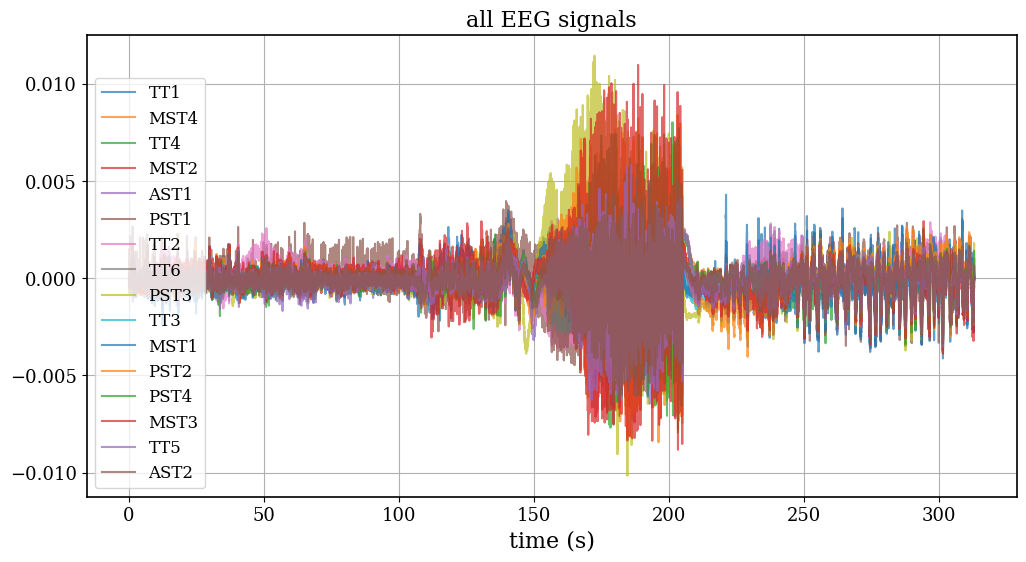

In [235]:

data = []
# filenames = []
for file in file_paths:
    # filenames.append(file)
    # file_path = os.path.join(folder_path, file)
    dataset = np.loadtxt(file, skiprows=1)

    data.append(dataset)

plt.figure(figsize=(12, 6))

for i, datensatz in enumerate(data):
    time = datensatz[:, 0]
    signal = datensatz[:, 1]
    plt.plot(time, signal, label=f'{channel_names[i]}', alpha=0.7)

plt.title("all EEG signals")
plt.xlabel("time (s)")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


Pretty plot for article

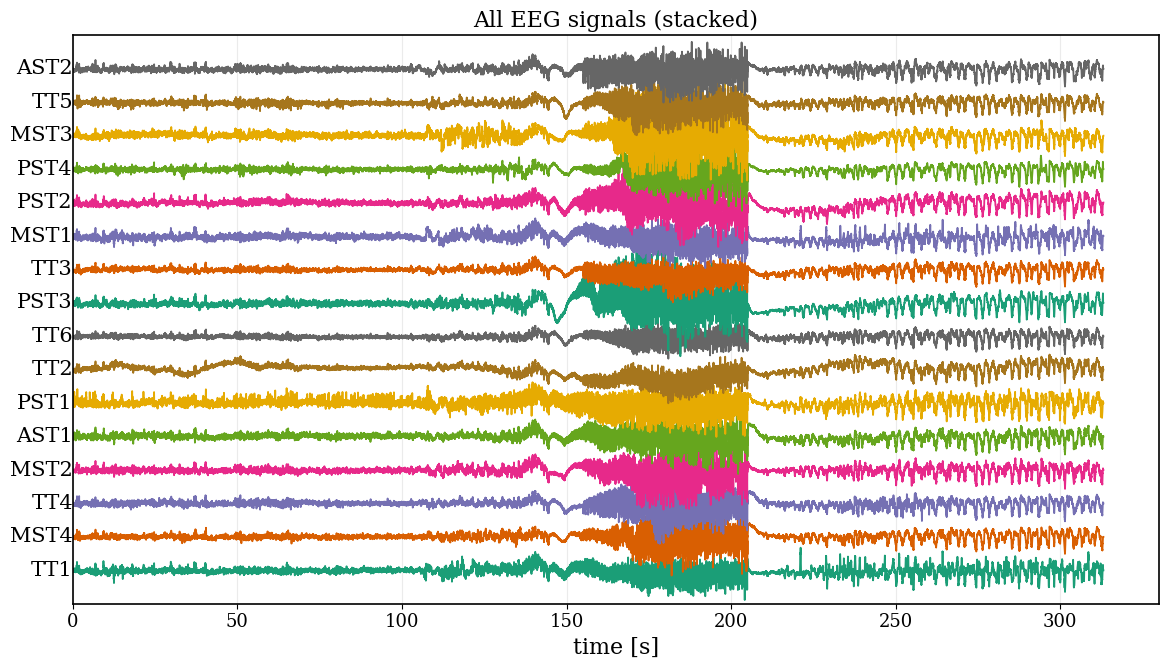

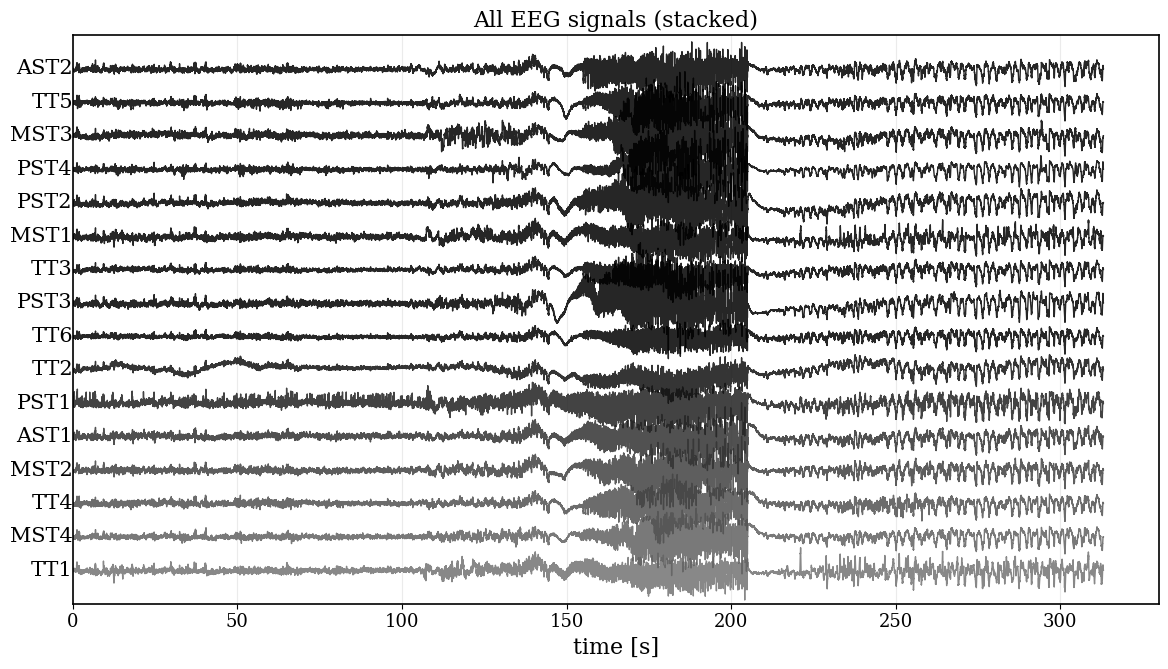

In [236]:


def plot_all_eeg_signals_stacked(
    file_paths,
    channel_names,
    patientID,
    mode="color",
    xlim=None,
    spacing=None,
    label_xpos=None,
    save=False
):

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 17,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "legend.fontsize": 12,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.linewidth": 1.2
    })

    # --- load data ---
    data = []
    for file in file_paths:
        dataset = np.loadtxt(file, skiprows=1)
        data.append(dataset)

    n_channels = len(data)

    # --- estimate spacing automatically if not given ---
    if spacing is None:
        # Use a robust amplitude estimate across channels
        all_ranges = []
        for datensatz in data:
            signal = datensatz[:, 1]
            p1, p99 = np.percentile(signal, [1, 99])
            all_ranges.append(p99 - p1)
        spacing = 1.2 * np.median(all_ranges)

    fig, ax = plt.subplots(figsize=(12, 7))

    # --- style switch ---
    if mode == "color":
        linewidth = 1.3
        alpha = 1
        cmap = plt.cm.Dark2

    elif mode == "bw":
        linewidth = 1
        alpha = 0.85
        cmap = plt.cm.gist_yarg

    else:
        raise ValueError("mode must be 'color' or 'bw'")

    # label placement (a bit left of plot start)
    if label_xpos is None:
        label_xpos = data[0][:, 0].min()

    # --- plot stacked signals ---
    for i, datensatz in enumerate(data):
        time = datensatz[:, 0]
        signal = datensatz[:, 1]

        offset = i * spacing

        if mode == "color":
            color = cmap(i % cmap.N)
        else:
            # avoid too light grays
            shade = 0.55 + 0.95 * (i / max(1, n_channels - 1))
            color = cmap(shade)

        ax.plot(
            time, signal + offset,
            linewidth=linewidth,
            alpha=alpha,
            color=color
        )

        # channel name label on the left
        ax.text(
            label_xpos, offset,
            channel_names[i],
            fontsize=15,
            verticalalignment="center",
            horizontalalignment="right"
        )

    # --- formatting ---
    ax.set_title("All EEG signals (stacked)")
    ax.set_xlabel("time [s]")
    ax.set_yticks([])  # cleaner

    # x limits if desired
    if xlim is not None:
        ax.set_xlim(xlim)

    # y limits
    ax.set_ylim(-spacing, n_channels * spacing)

    ax.grid(True, axis="x", alpha=0.25)
    ax.grid(False, axis="y")

    plt.tight_layout()

    if save:

        plt.savefig(
            f"output/patient_{patientID}_all_EEG_{mode}.pdf",
            format="pdf",
            bbox_inches="tight"
        )

    plt.show()


plot_all_eeg_signals_stacked(file_paths, channel_names, patientID, mode="color", xlim=(0, 330))
plot_all_eeg_signals_stacked(file_paths, channel_names, patientID, mode="bw", xlim=(0, 330))


## Data Preprocessing
The signals do not necessarily have the exact same length, so let's correct that. I also remove the time column of every dataset. 

In [237]:
for i, d in enumerate(data):
    print(f"Datensatz {i+1}: Shape {d.shape}")

min_len = min(d.shape[0] for d in data)
signals_only = np.array([d[:min_len, 1] for d in data])  # keep only signal vector, omit time vector
times_only = np.array([d[:min_len, 0] for d in data])
print('size of the whole data matrix: ', signals_only.shape)  

Datensatz 1: Shape (313110, 2)
Datensatz 2: Shape (313110, 2)
Datensatz 3: Shape (313110, 2)
Datensatz 4: Shape (313110, 2)
Datensatz 5: Shape (313110, 2)
Datensatz 6: Shape (313110, 2)
Datensatz 7: Shape (313110, 2)
Datensatz 8: Shape (313111, 2)
Datensatz 9: Shape (313110, 2)
Datensatz 10: Shape (313110, 2)
Datensatz 11: Shape (313110, 2)
Datensatz 12: Shape (313110, 2)
Datensatz 13: Shape (313110, 2)
Datensatz 14: Shape (313110, 2)
Datensatz 15: Shape (313111, 2)
Datensatz 16: Shape (313110, 2)
size of the whole data matrix:  (16, 313110)


### Alternative way of plotting

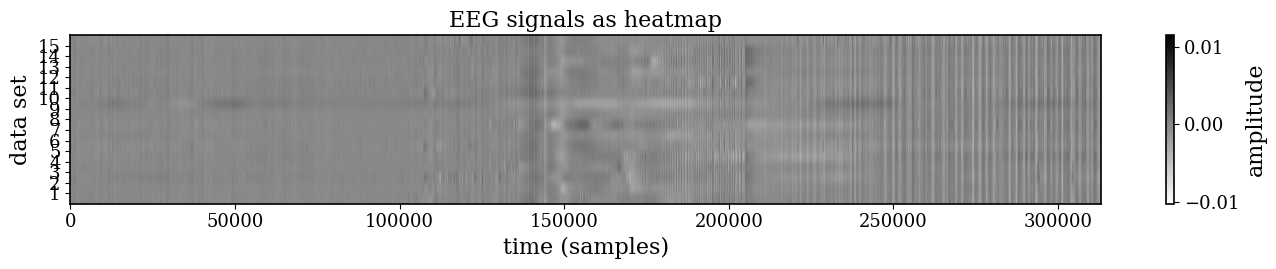

In [238]:
plt.figure(figsize=(14, 3))
plt.imshow(signals_only, aspect='auto', cmap='binary', extent=[0, signals_only.shape[1], 0, signals_only.shape[0]])
plt.colorbar(label='amplitude')
plt.xlabel("time (samples)")
plt.ylabel("data set")
plt.yticks(np.arange(1,len(channel_names)))
plt.title("EEG signals as heatmap")
plt.tight_layout()
plt.show()


## Rolling Range of $\sum a^4$:
Rolling range: Let's stay within one EEG sensor. There, we take small ranges (16 consecutive points) and compute for example again $\sum a^4$.

Let's consider only one first EEG channel, and compare the classical with the quantum computation:

In [239]:
# Choose the channel to work on
channel = 4
print(channel_names[channel])

AST1


### Classical

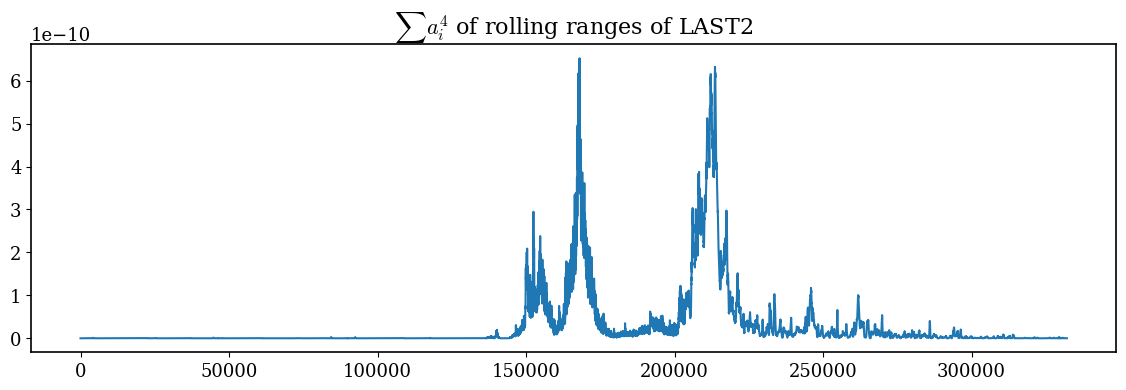

In [193]:


rolling_sum4 = []
for time in range(0,signals_only.shape[1] - 16):
    
    vector = signals_only[channel, time:time+16]
    vector_norm = np.linalg.norm(vector)  # if we do it quantum, we need to normalize the vector but save the norm so that we can rescale
    if vector_norm == 0:
        rolling_sum4.append(0)
        continue
    vector = vector / vector_norm
    classical_sum4 = np.sum(vector**4)
    rolling_sum4.append(classical_sum4 * vector_norm**4)  # rescale with norm to get back to physical context

plt.figure(figsize=(14,4))
plt.plot(rolling_sum4)
plt.title(rf'$\sum a_i^4$ of rolling ranges of {channel_names[channel]}')
plt.show()

### Quantum
The observable will be the same as before. So no need to set it up again.

In [241]:
num_qubits = 4

# Observable ###########################################
pauli_strings = []
translation_map = str.maketrans("01", "IZ")
for j in range(2**num_qubits):
    binary_string = (format(j,'04b'))
    IZ_string = binary_string.translate(translation_map)
    pauli_strings.append(IZ_string + IZ_string)
pauli_coeffs = 1/2**num_qubits * np.ones(2**num_qubits)
spo = SparsePauliOp(pauli_strings, pauli_coeffs)

# prepare the state twice in parallel and measure observable
# channel = 1

times = []
quantum_rolling_sum4 = []
for time in range(0, signals_only.shape[1] - 16):
    times.append(time)
    vector = signals_only[channel, time:time+16]
    vector_norm = np.linalg.norm(vector)
    if vector_norm == 0:
        quantum_rolling_sum4.append(0)
        continue
    normalized_vector = vector / vector_norm
    
    qc_double=QuantumCircuit(2*num_qubits)
    qc_double.initialize(normalized_vector, qubits=range(num_qubits))
    qc_double.initialize(normalized_vector, qubits=range(num_qubits,2*num_qubits))

    quantum_rolling_sum4.append(np.real(Statevector(qc_double).expectation_value(spo)) * vector_norm**4)

rolling_sum4 = np.array(rolling_sum4)
quantum_rolling_sum4 = np.array(quantum_rolling_sum4)

with open(f'computed_sonification_data/patient{patientID}_quantum_rolling_a4_{channel_names[channel]}.txt', 'w') as f:
    for i in range(len(times)):
        f.write(f"{times[i]} {quantum_rolling_sum4[i]}\n")


# plt.figure(figsize=(14,4))
# plt.plot(np.arange(signals_only.shape[1]-16), rolling_sum4, label='classical')
# plt.plot(times, quantum_rolling_sum4, label='quantum')
# plt.xlabel('time (samples)')
# plt.legend()
# plt.title(rf'$\sum a_i^4$ of rolling ranges of {channel_names[channel]}')
# plt.show()

Pretty Plot for the article

In [242]:

def plot_classical_quantum_comparison(
    rolling_sum4,
    quantum_rolling_sum4,
    times,
    signals_only,
    channel_name,
    mode="color"   # "color" or "bw"
):
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "legend.fontsize": 13,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.linewidth": 1.2
    })

    t = times[:-16]
    
    delta = quantum_rolling_sum4 - rolling_sum4

    fig, (ax, ax_delta) = plt.subplots(
        2, 1, figsize=(14, 5),
        gridspec_kw={"height_ratios": [5, 1]},
        sharex=True
    )

    # --- styling switch ---
    if mode == "color":
        quantum_color = "#385BBB"
        classical_face = "#8B97CB"
        classical_edge = "black"
        hatch = "///"
        quantum_alpha = 0.75
        classical_alpha = 0.8
        delta_color = quantum_color

        classical_label = "Classical Reference"
        quantum_label = "Quantum Circuit Results"

    elif mode == "bw":
        quantum_color = "black"
        classical_face = "none"
        classical_edge = "black"
        hatch = "///"
        quantum_alpha = 1.0
        classical_alpha = 1.0
        delta_color = "black"

        classical_label = "Classical Reference"
        quantum_label = "Quantum Circuit Results"

    else:
        raise ValueError("mode must be 'color' or 'bw'")

    # --- main plot ---
    ax.fill_between(
        t, rolling_sum4,
        facecolor=classical_face,
        edgecolor=classical_edge,
        hatch=hatch,
        linewidth=0.8,
        alpha=classical_alpha,
        label=classical_label,
        rasterized=True
    )

    ax.plot(
        t, quantum_rolling_sum4,
        color=quantum_color,
        linewidth=2.9,
        alpha=quantum_alpha,
        label=quantum_label,
        rasterized=True
    )

    ax.set_title(rf'$\sum a_i^4$ of rolling ranges of {channel_name}')
    ax.set_ylabel(r'$a^4$')
    ax.legend(frameon=False)
    ax.grid(True, alpha=0.25)

    ax_delta.plot(t, delta, color=delta_color, linewidth=1.5, rasterized=True)
    ax_delta.axhline(0, color="0.3", linestyle=":", linewidth=1)

    ax_delta.set_ylabel(r"Resid.")
    ax_delta.set_xlabel("time [s]")
    ax_delta.grid(True, alpha=0.25)

    plt.tight_layout()
    plt.savefig(f"output/patient_{patientID}_quantum_rolling_a4_{channel_name}_{mode}.pdf", format="pdf", bbox_inches="tight", dpi=300)
    # plt.show()


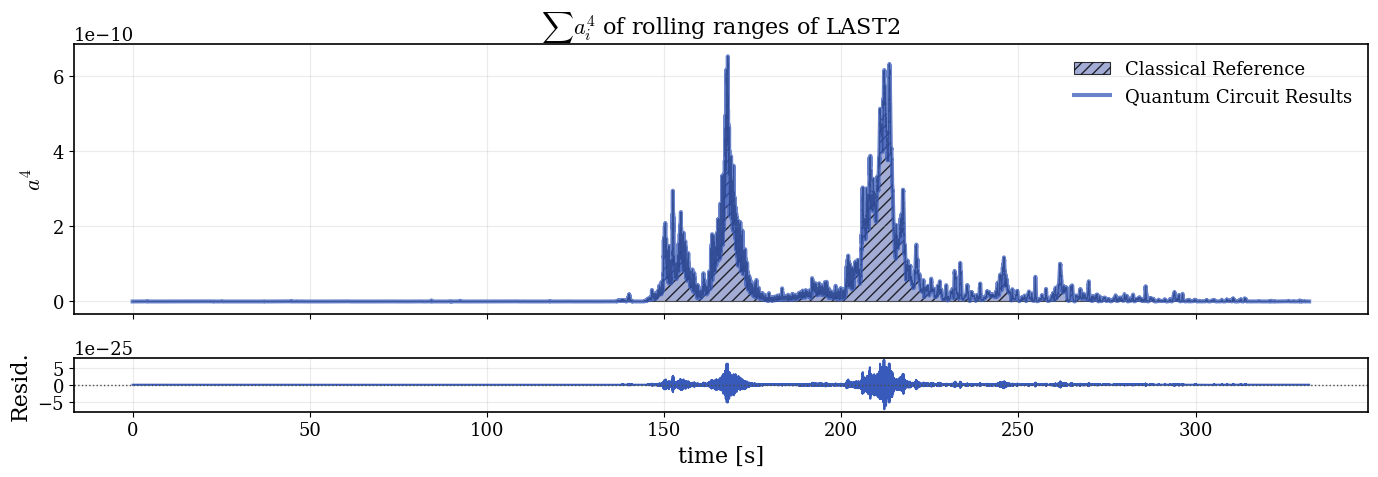

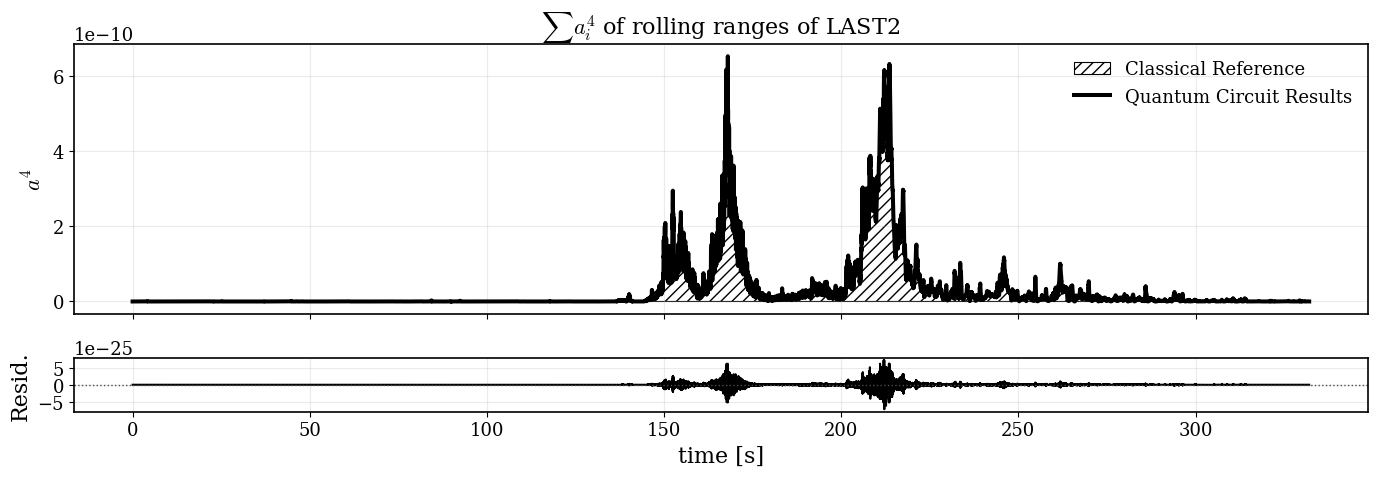

In [191]:

plot_classical_quantum_comparison(rolling_sum4, quantum_rolling_sum4, times_only[channel], signals_only, channel_names[channel], mode="color")
plot_classical_quantum_comparison(rolling_sum4, quantum_rolling_sum4, times_only[channel], signals_only, channel_names[channel], mode="bw")
# print('done')

In [243]:
def full_a4(channel):
        
    
    rolling_sum4 = []
    for time in range(0,signals_only.shape[1] - 16):
        
        vector = signals_only[channel, time:time+16]
        vector_norm = np.linalg.norm(vector)  # if we do it quantum, we need to normalize the vector but save the norm so that we can rescale
        if vector_norm == 0:
            rolling_sum4.append(0)
            continue
        vector = vector / vector_norm
        classical_sum4 = np.sum(vector**4)
        rolling_sum4.append(classical_sum4 * vector_norm**4)  # rescale with norm to get back to physical context
    
    plt.figure(figsize=(14,4))
    plt.plot(rolling_sum4)
    plt.title(rf'$\sum a_i^4$ of rolling ranges of {channel_names[channel]}')
    # plt.show()
    
    
    num_qubits = 4
    
    # Observable ###########################################
    pauli_strings = []
    translation_map = str.maketrans("01", "IZ")
    for j in range(2**num_qubits):
        binary_string = (format(j,'04b'))
        IZ_string = binary_string.translate(translation_map)
        pauli_strings.append(IZ_string + IZ_string)
    pauli_coeffs = 1/2**num_qubits * np.ones(2**num_qubits)
    spo = SparsePauliOp(pauli_strings, pauli_coeffs)
    
    # prepare the state twice in parallel and measure observable
    # channel = 1
    
    times = []
    quantum_rolling_sum4 = []
    for time in range(0, signals_only.shape[1] - 16):
        times.append(time)
        vector = signals_only[channel, time:time+16]
        vector_norm = np.linalg.norm(vector)
        if vector_norm == 0:
            quantum_rolling_sum4.append(0)
            continue
        normalized_vector = vector / vector_norm
        
        qc_double=QuantumCircuit(2*num_qubits)
        qc_double.initialize(normalized_vector, qubits=range(num_qubits))
        qc_double.initialize(normalized_vector, qubits=range(num_qubits,2*num_qubits))
    
        quantum_rolling_sum4.append(np.real(Statevector(qc_double).expectation_value(spo)) * vector_norm**4)
    
    rolling_sum4 = np.array(rolling_sum4)
    quantum_rolling_sum4 = np.array(quantum_rolling_sum4)
    
    with open(f'computed_sonification_data/patient{patientID}_quantum_rolling_a4_{channel_names[channel]}.txt', 'w') as f:
        for i in range(len(times)):
            f.write(f"{times[i]} {quantum_rolling_sum4[i]}\n")
    
    
    plot_classical_quantum_comparison(rolling_sum4, quantum_rolling_sum4, times_only[channel], signals_only, channel_names[channel], mode="color")
    plot_classical_quantum_comparison(rolling_sum4, quantum_rolling_sum4, times_only[channel], signals_only, channel_names[channel], mode="bw")
    # print(f'done{channel_names[channel]')
    # plt.figure(figsize=(14,4))
    # plt.plot(np.arange(signals_only.shape[1]-16), rolling_sum4, label='classical')
    # plt.plot(times, quantum_rolling_sum4, label='quantum')
    # plt.xlabel('time (samples)')
    # plt.legend()
    # plt.title(rf'$\sum a_i^4$ of rolling ranges of {channel_names[channel]}')
    # plt.show()

 38%|████████████████████████████████████████████▋                                                                          | 6/16 [57:27<1:35:36, 573.68s/it]/tmp/ipykernel_536811/2311753521.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax, ax_delta) = plt.subplots(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [2:18:30<00:00, 519.39s/it]


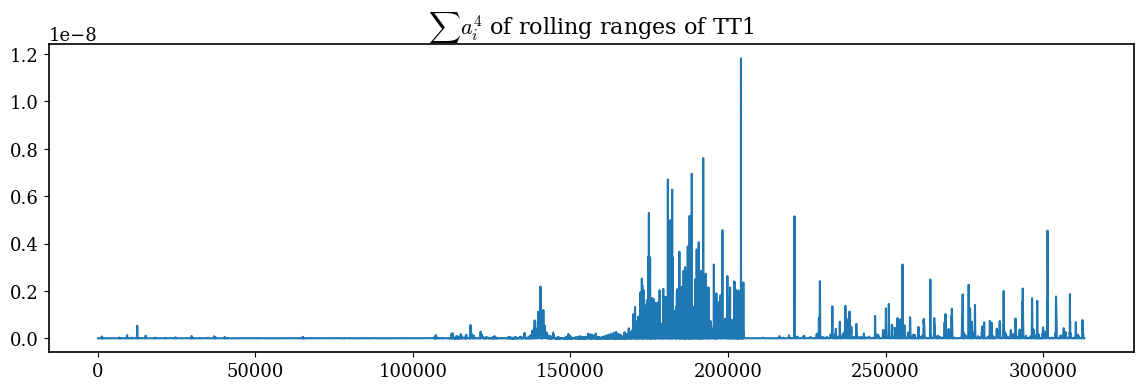

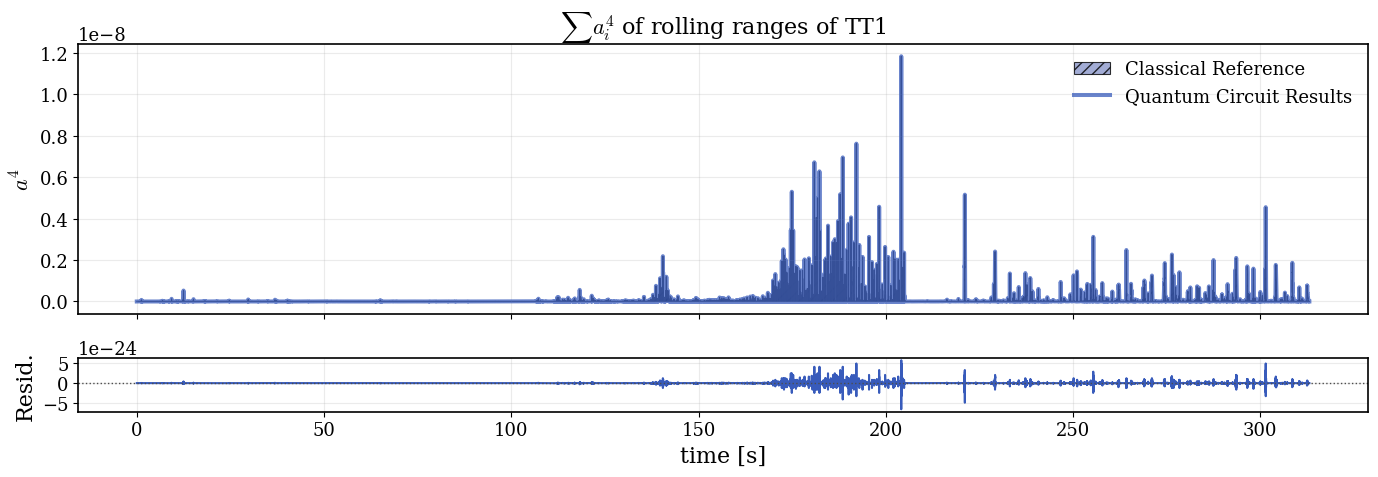

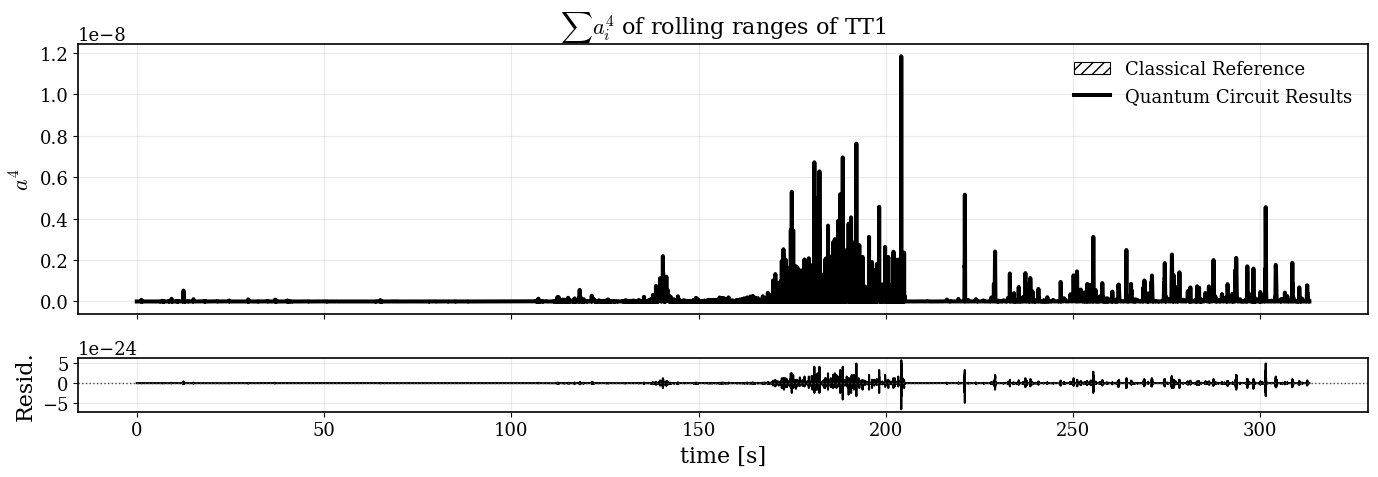

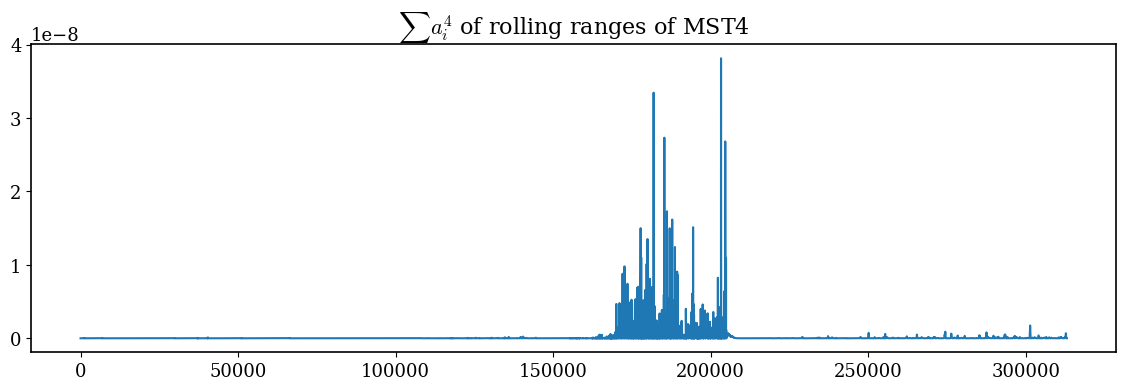

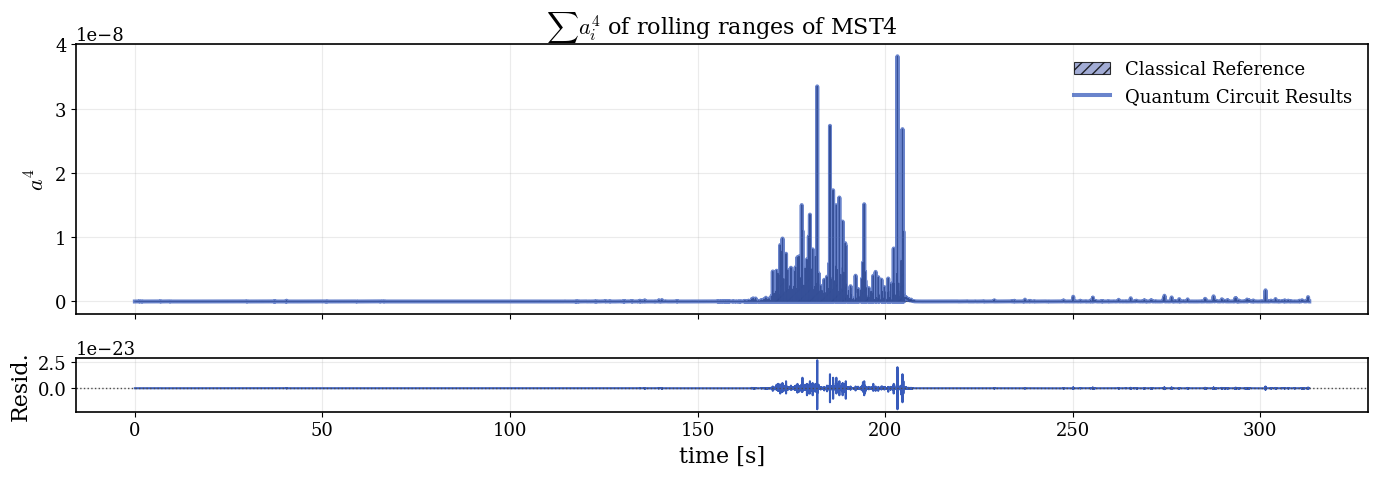

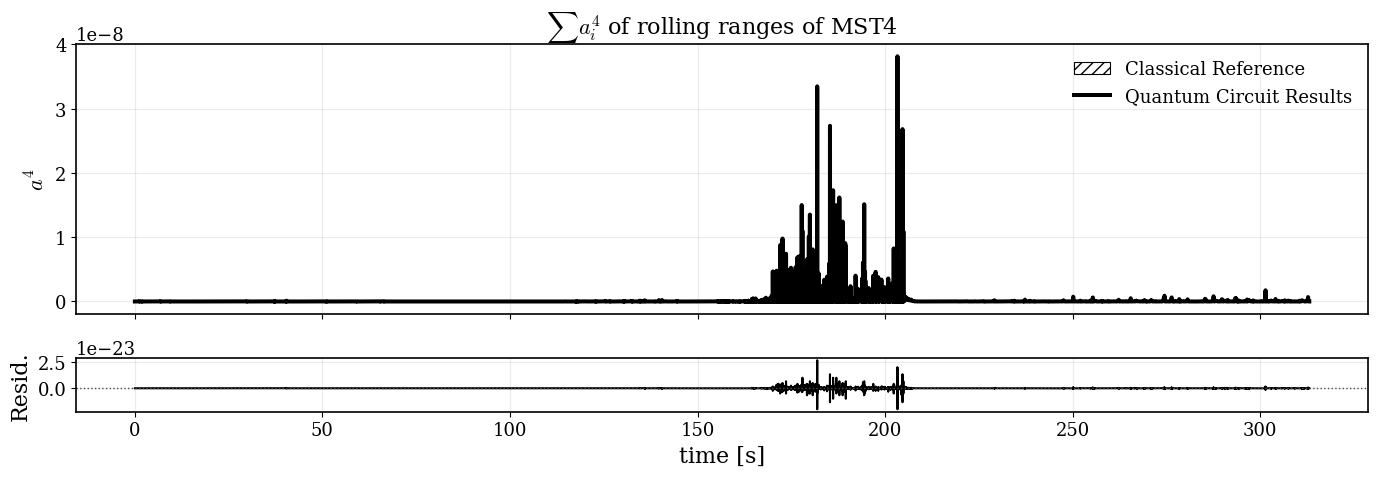

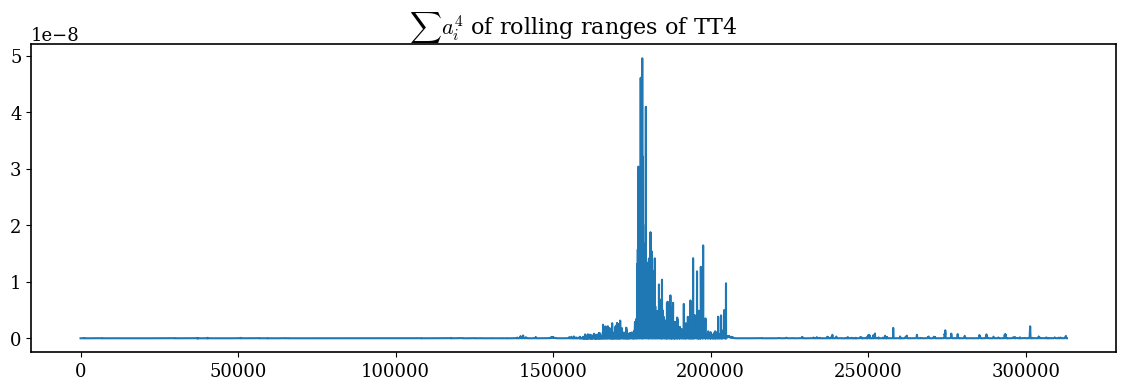

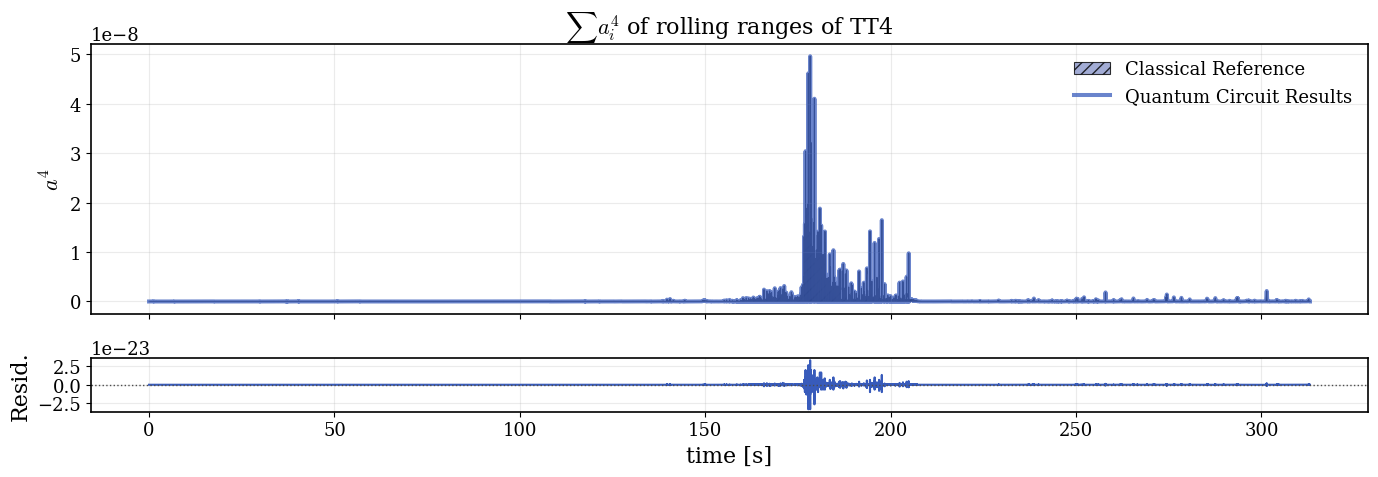

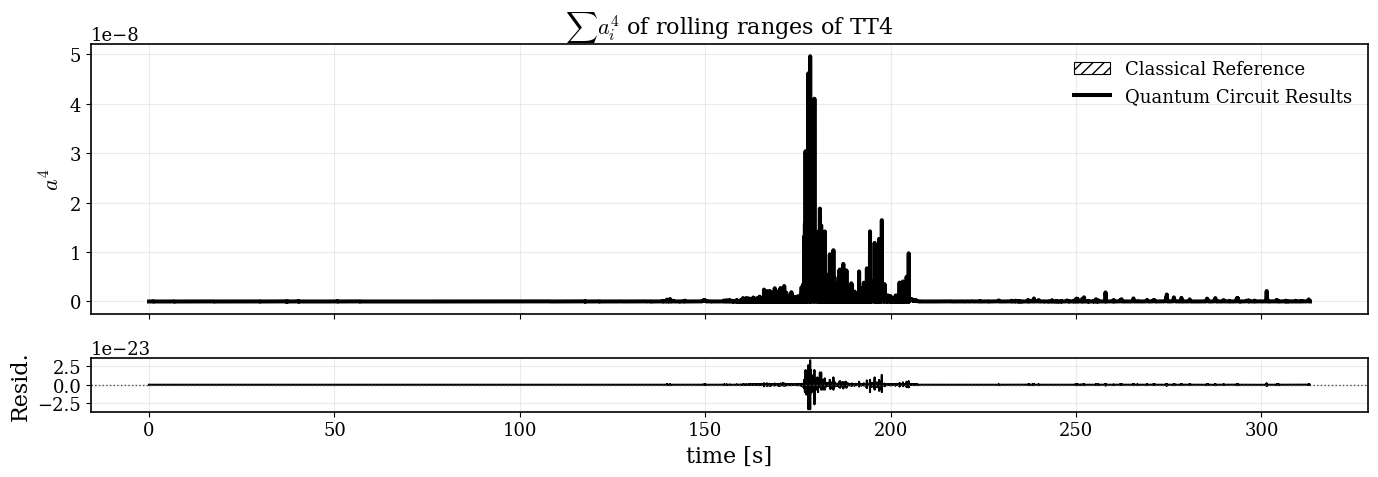

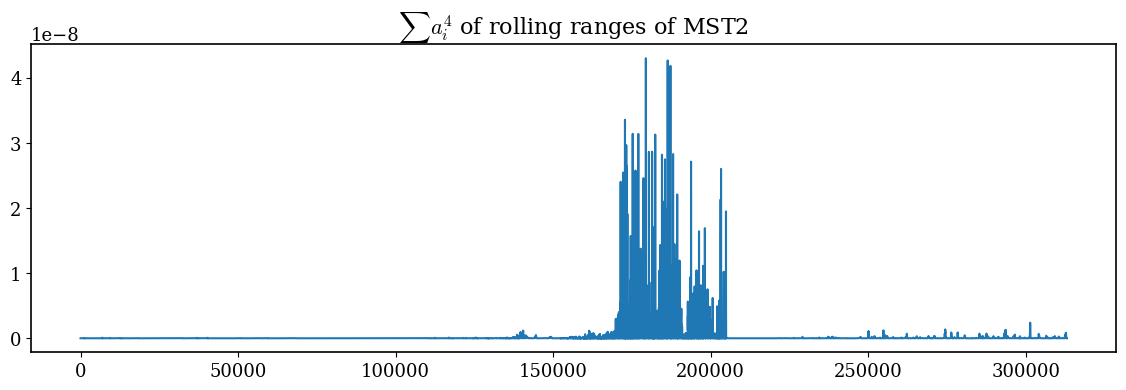

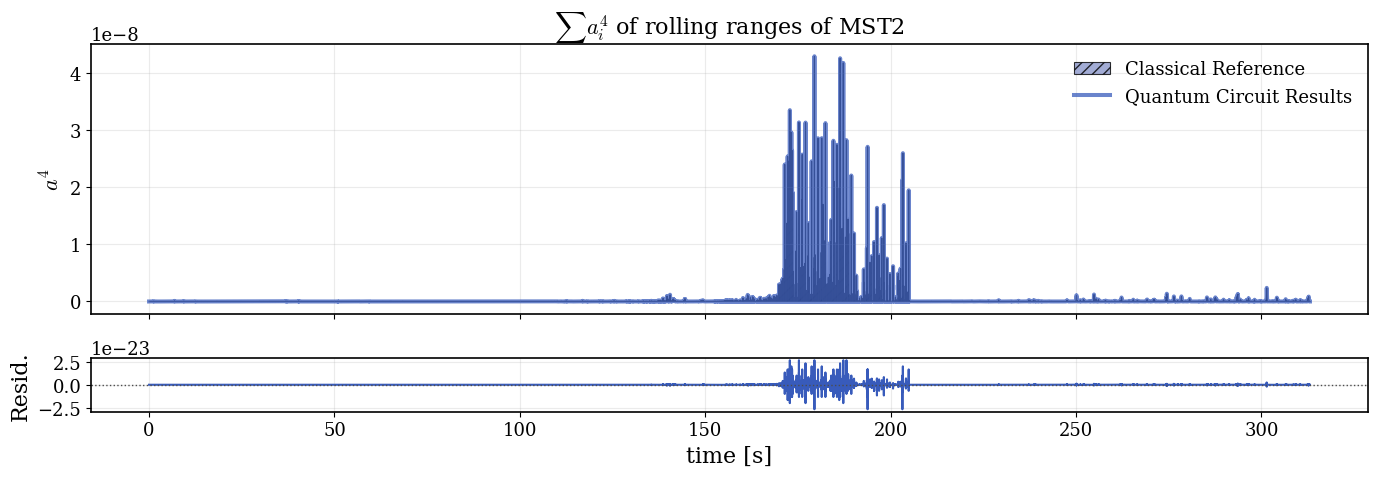

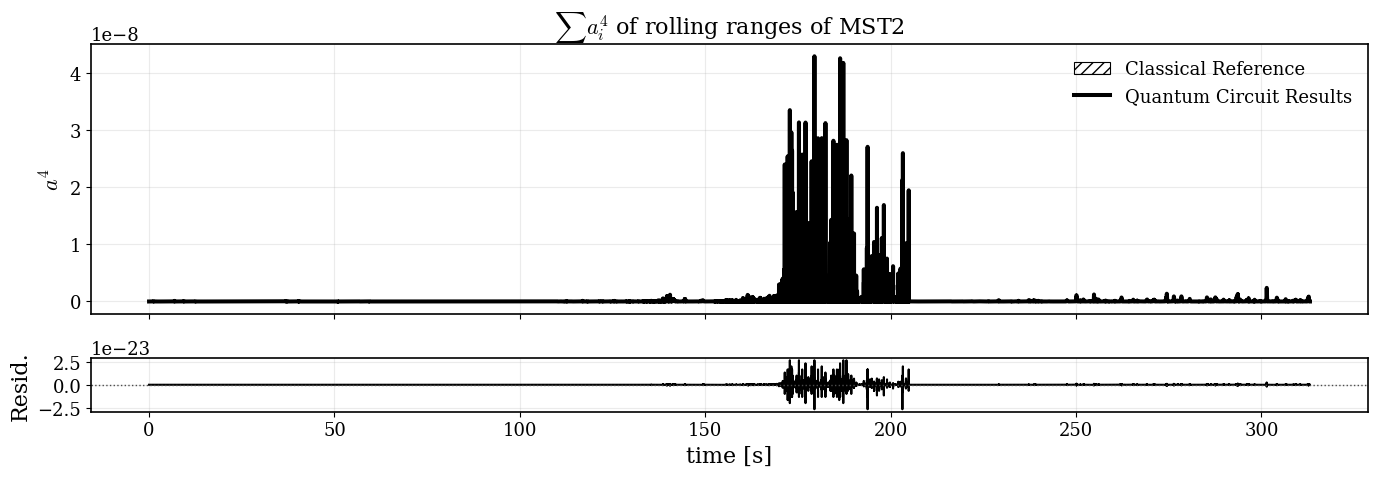

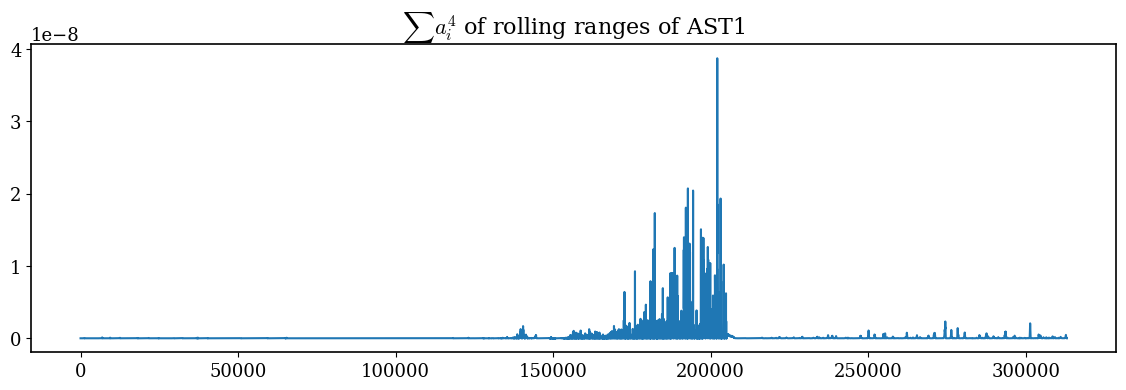

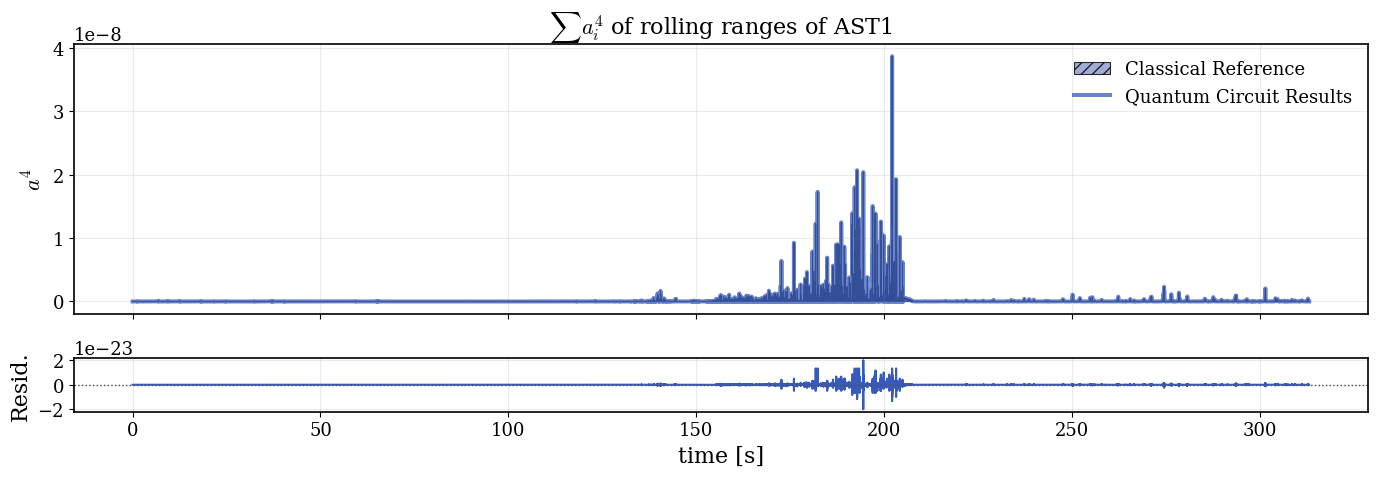

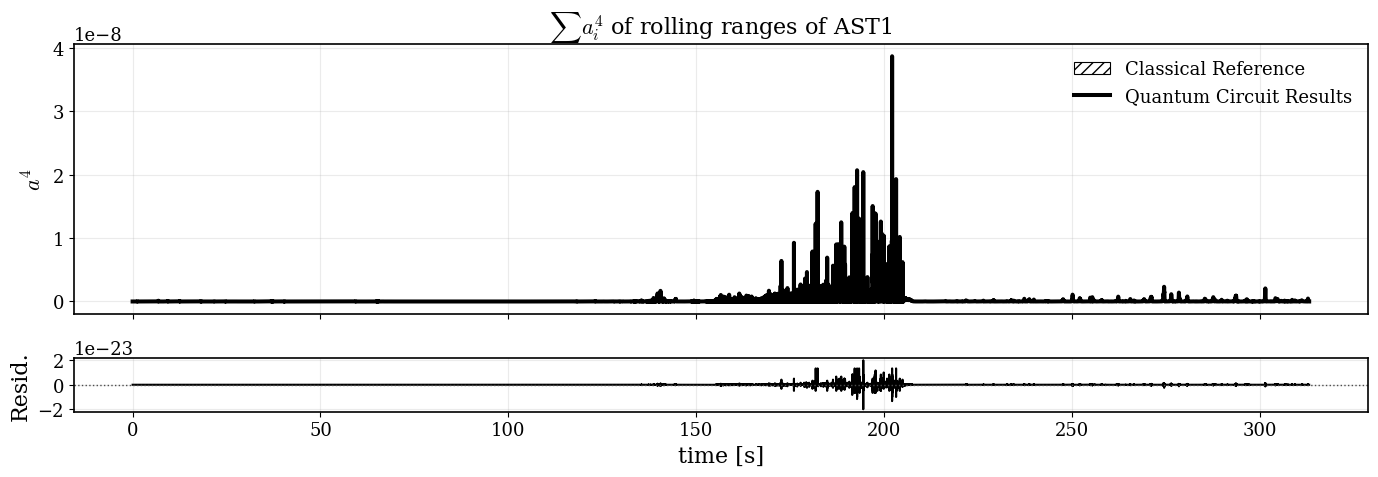

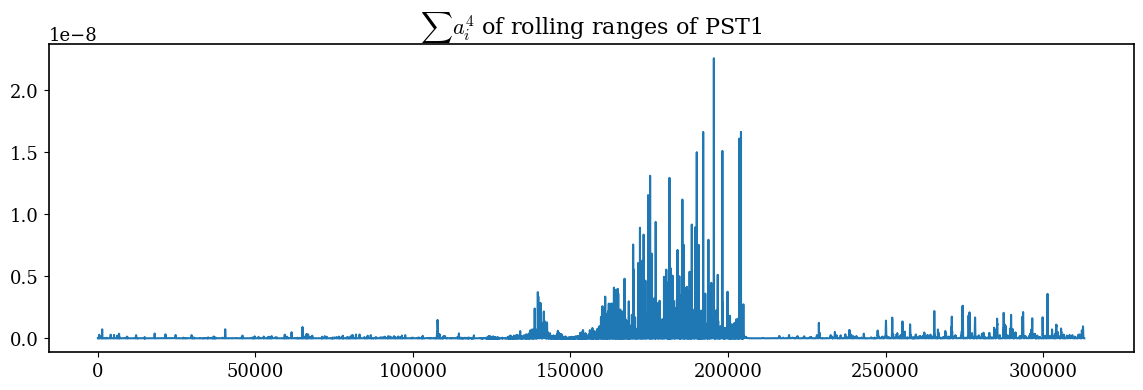

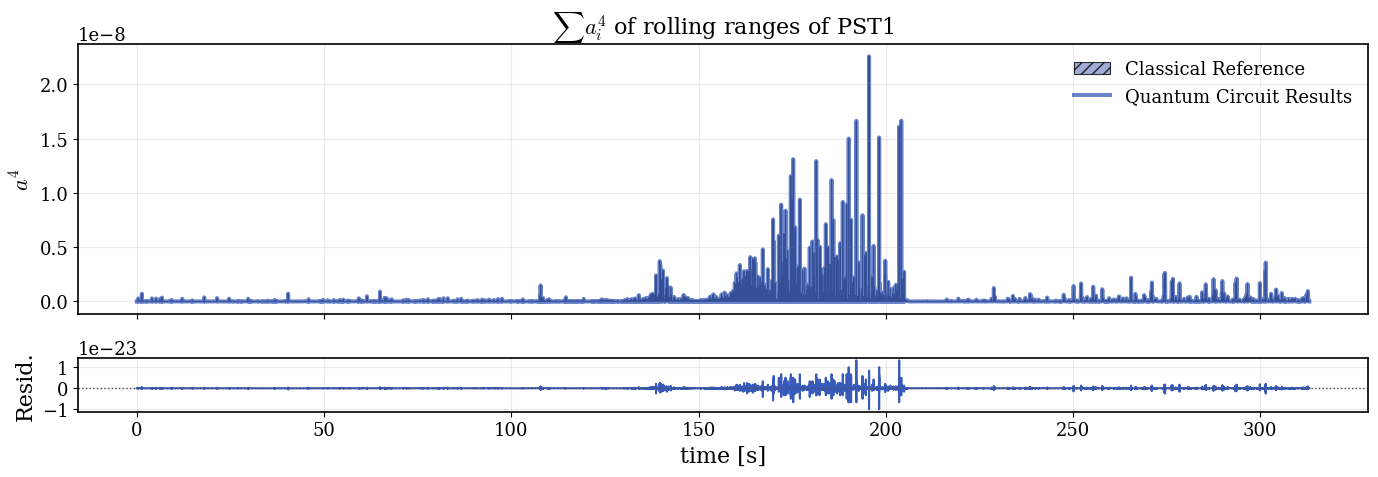

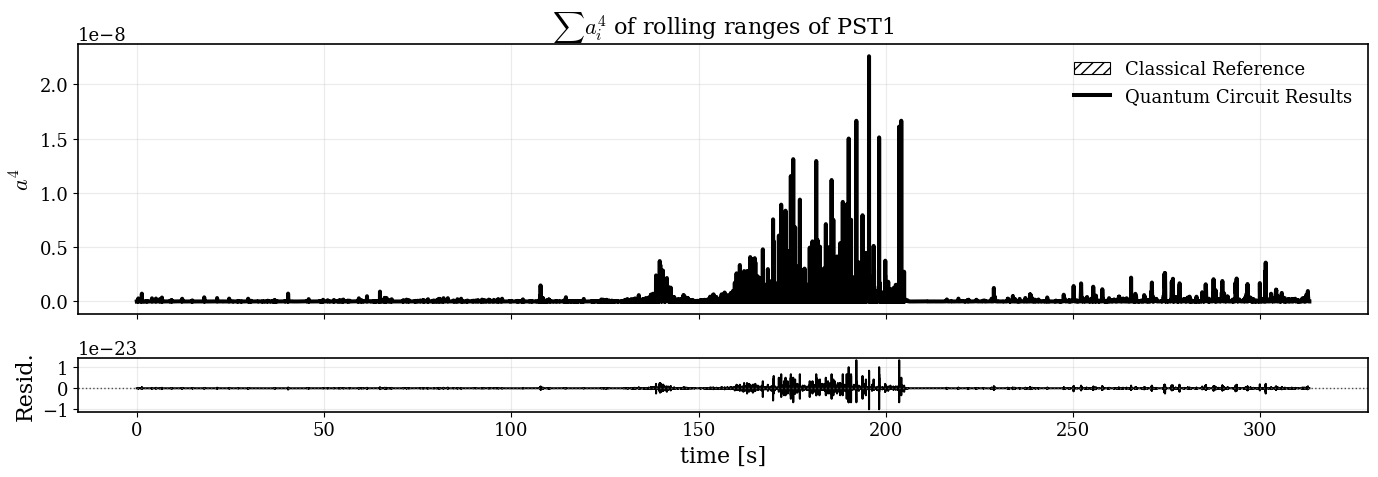

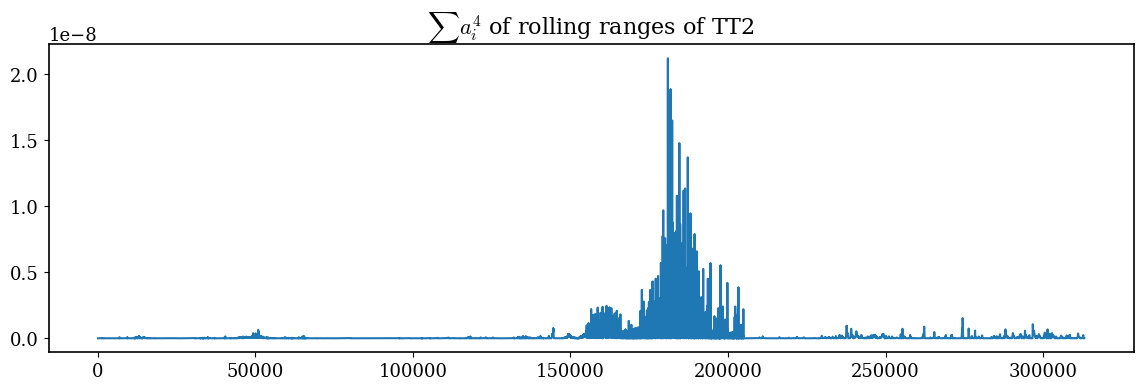

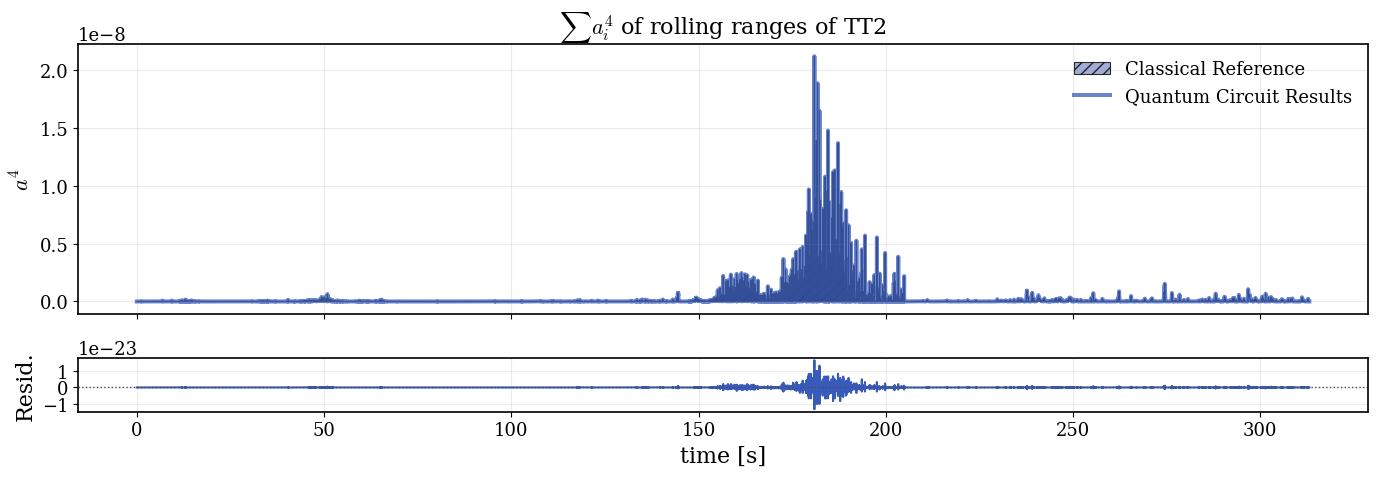

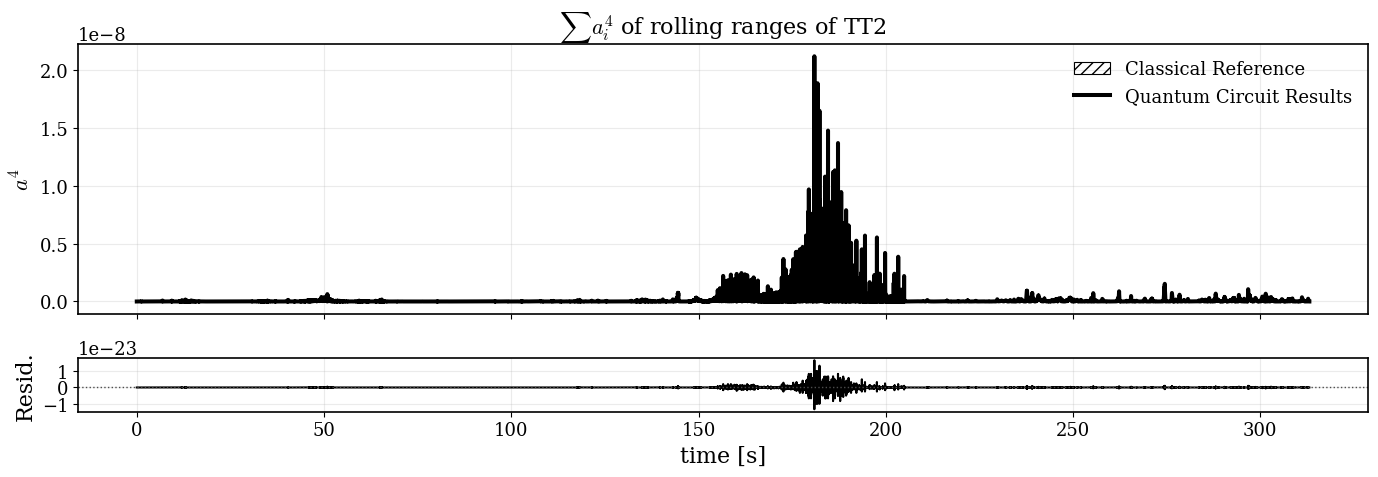

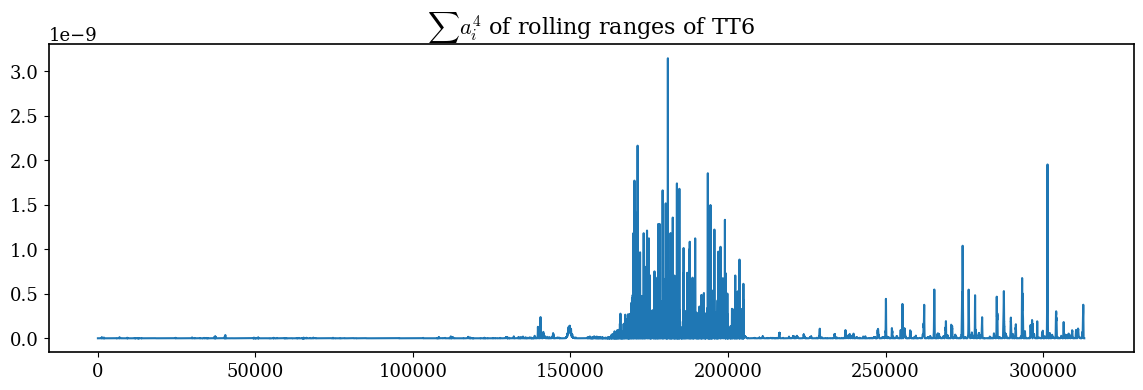

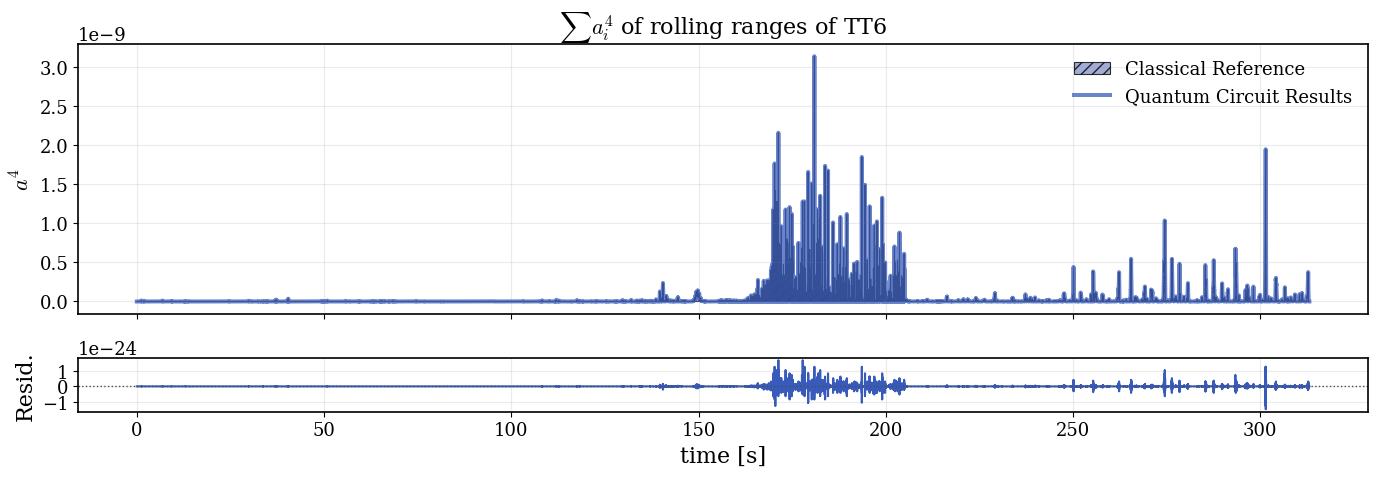

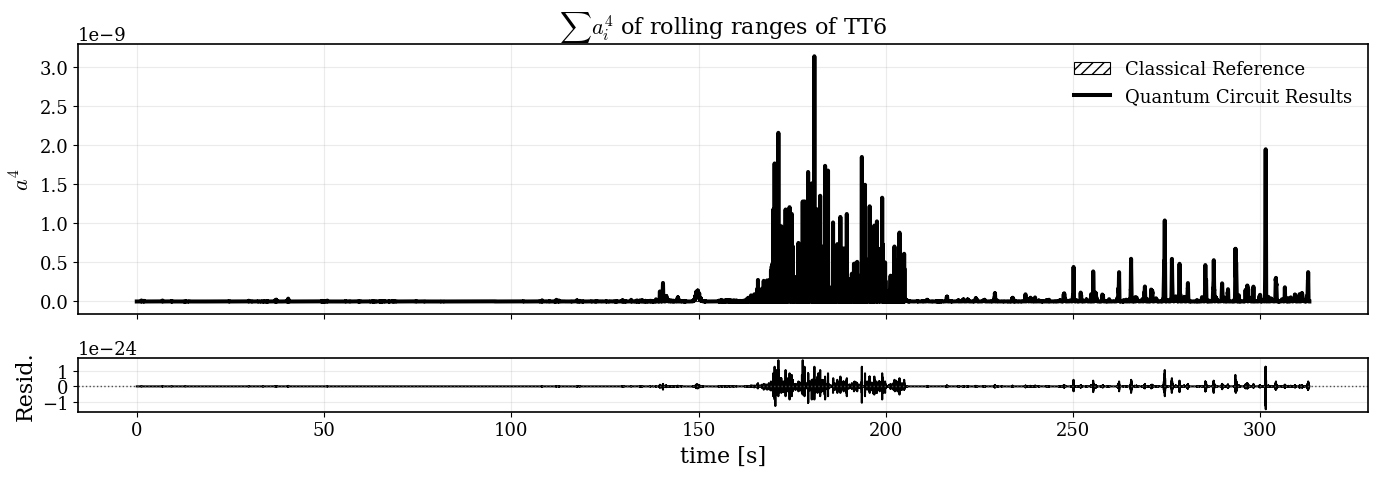

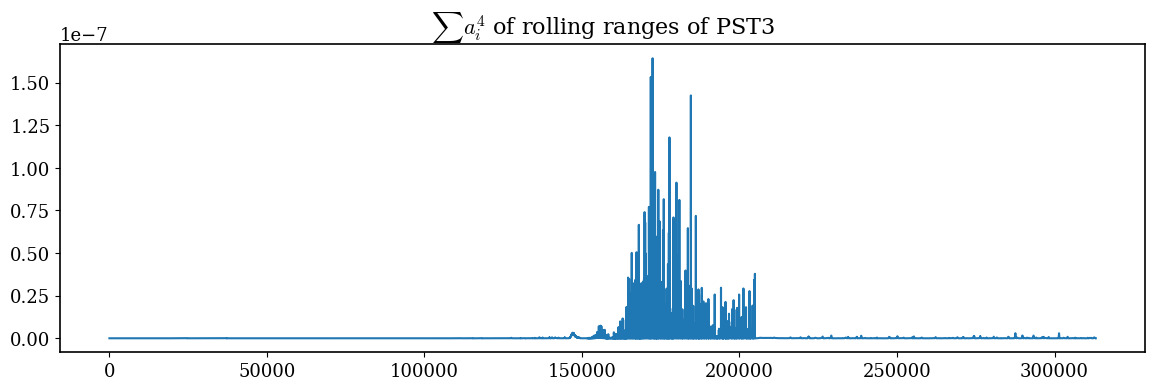

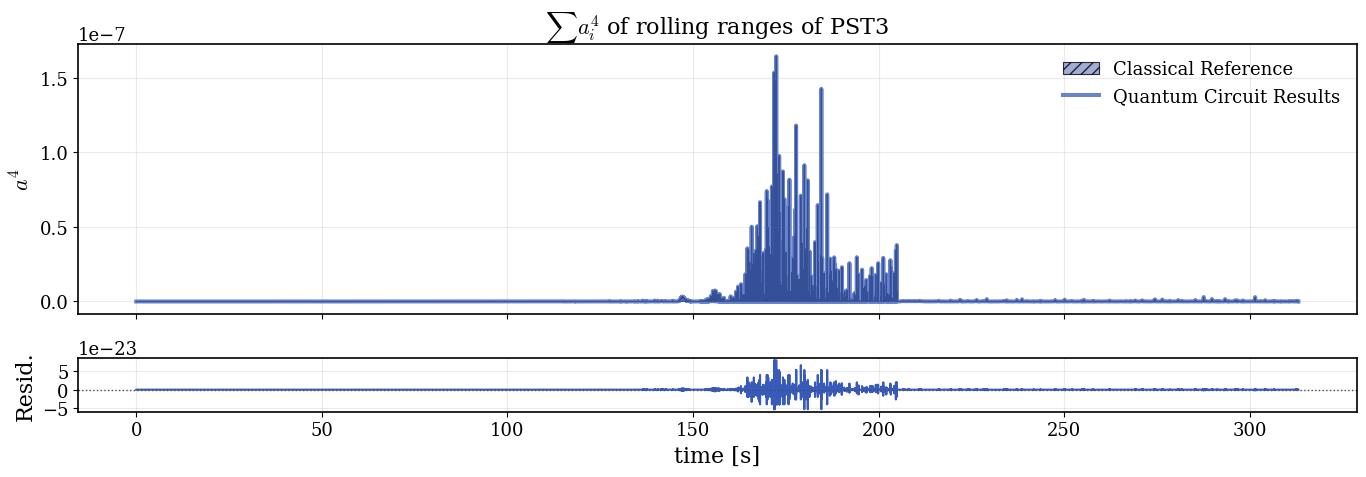

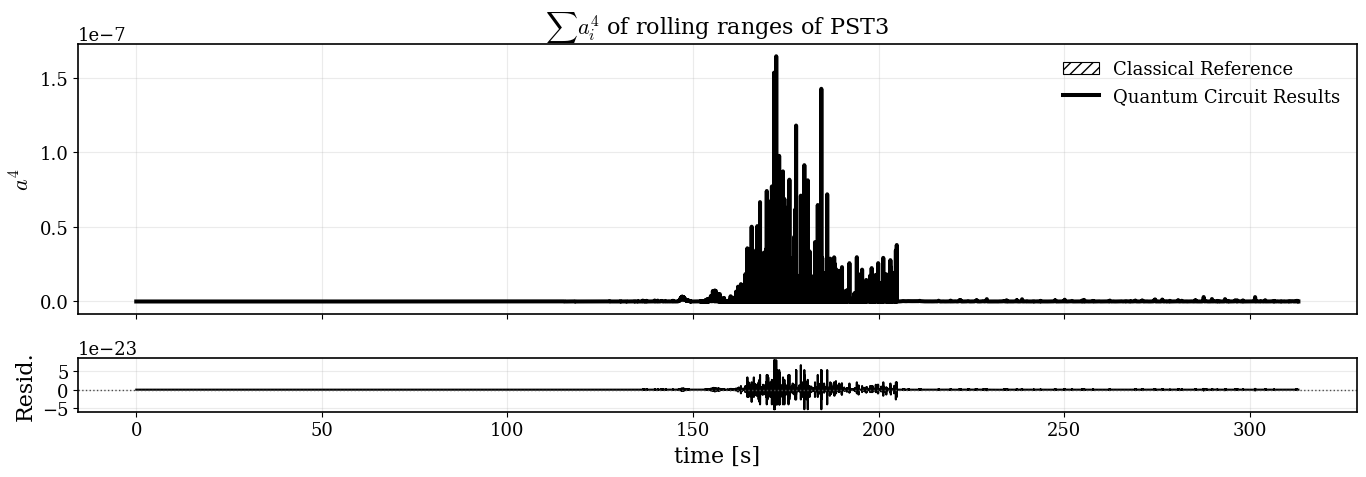

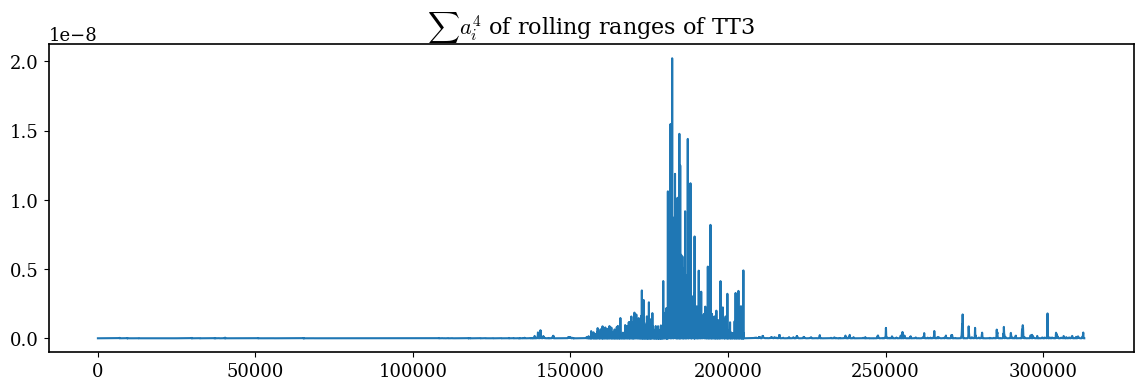

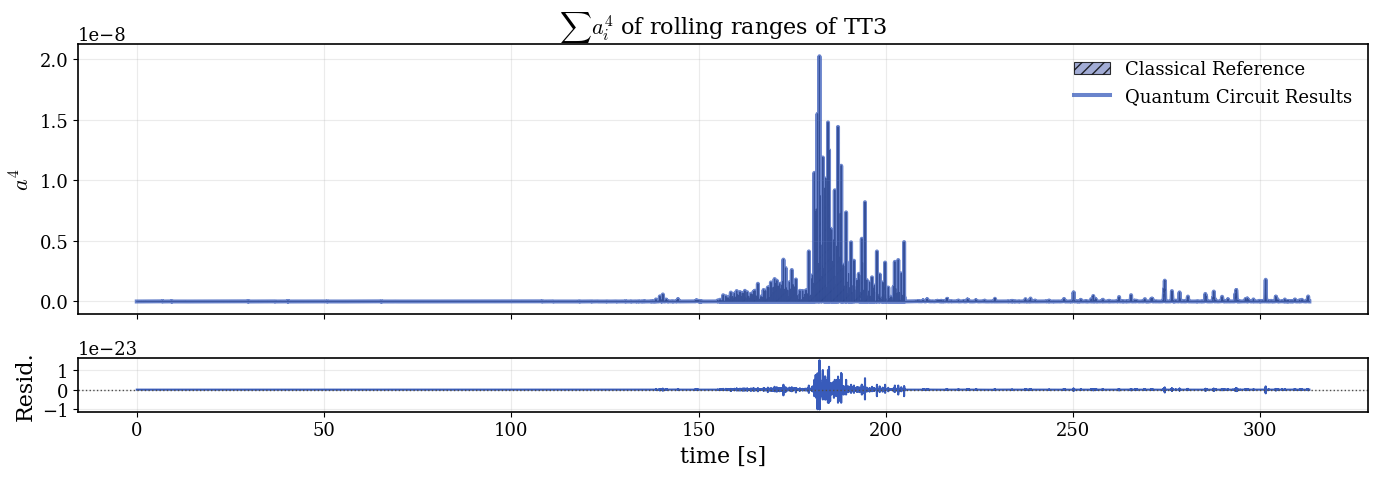

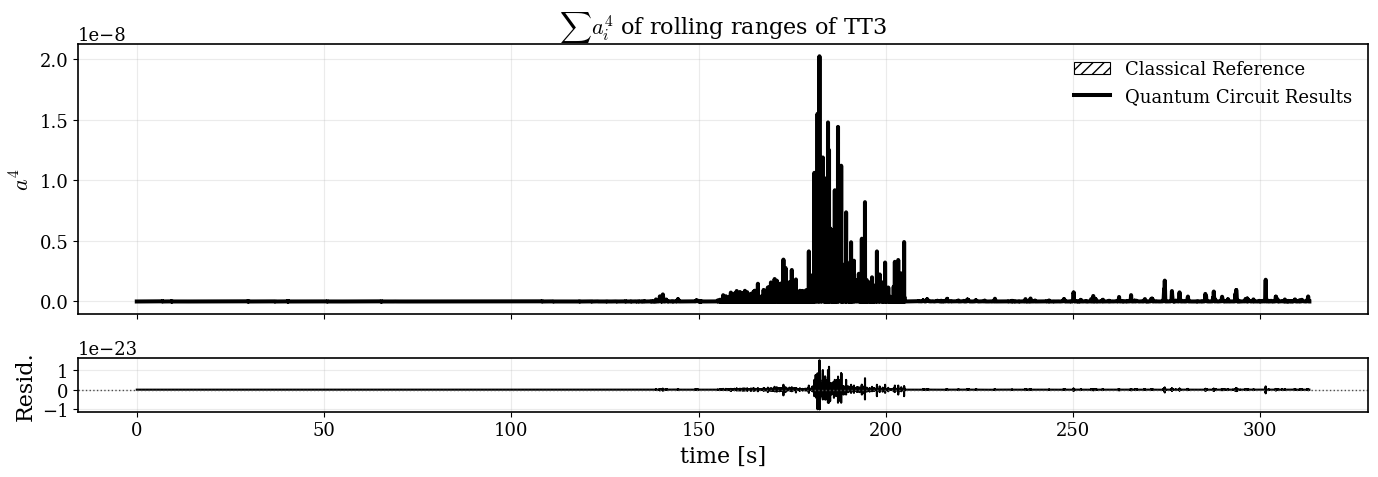

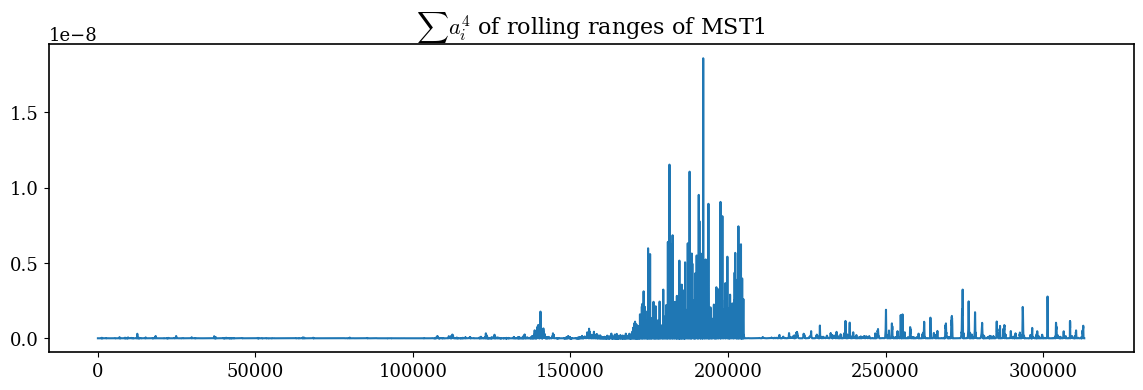

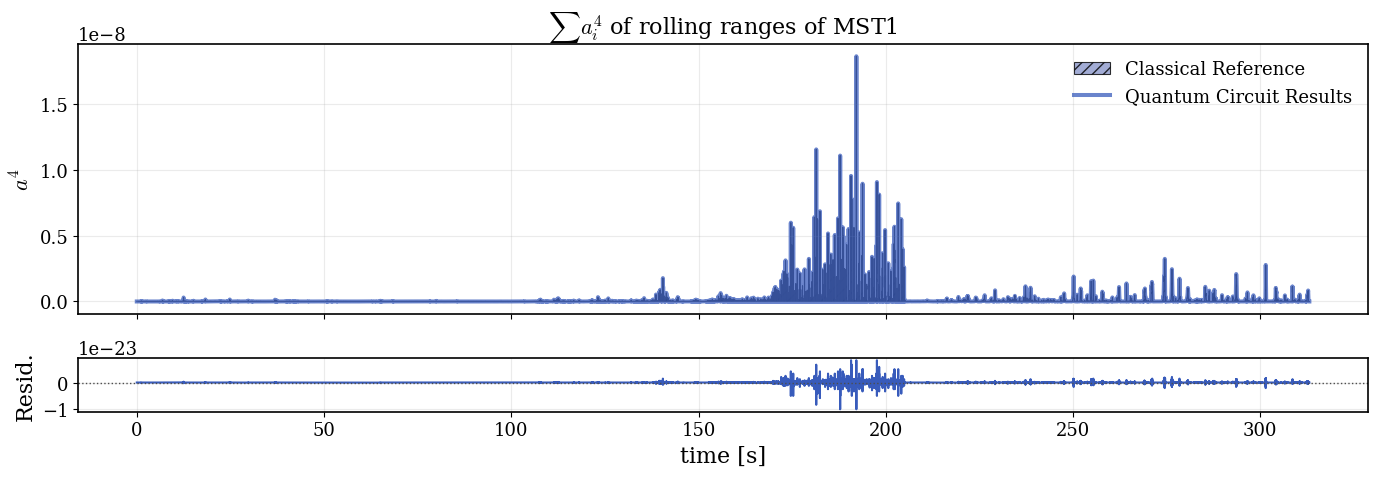

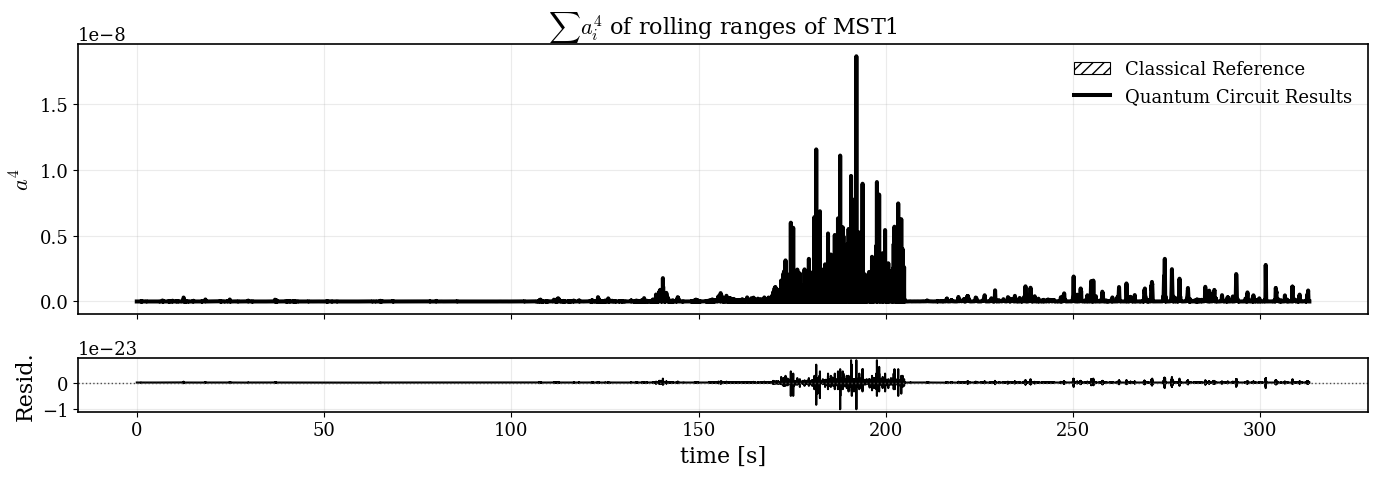

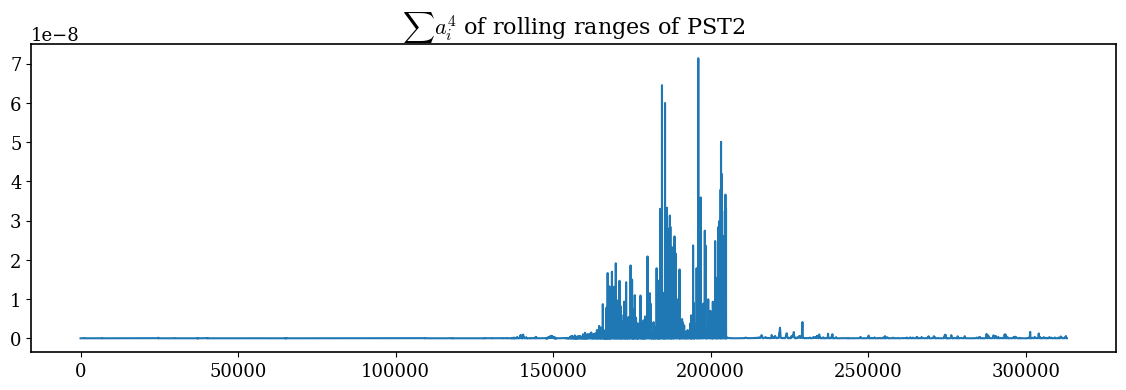

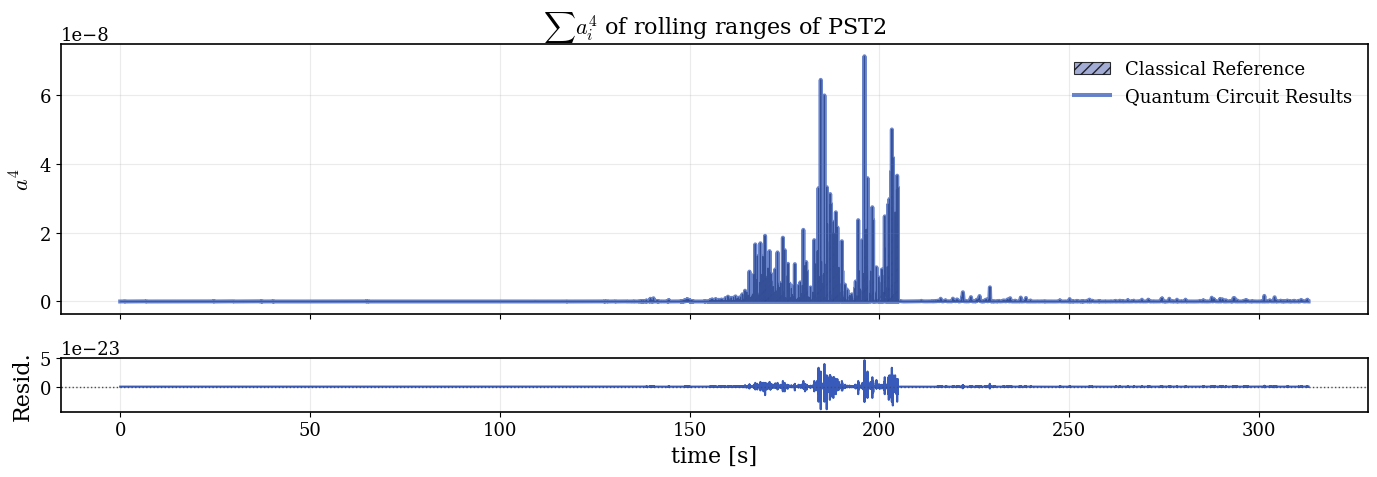

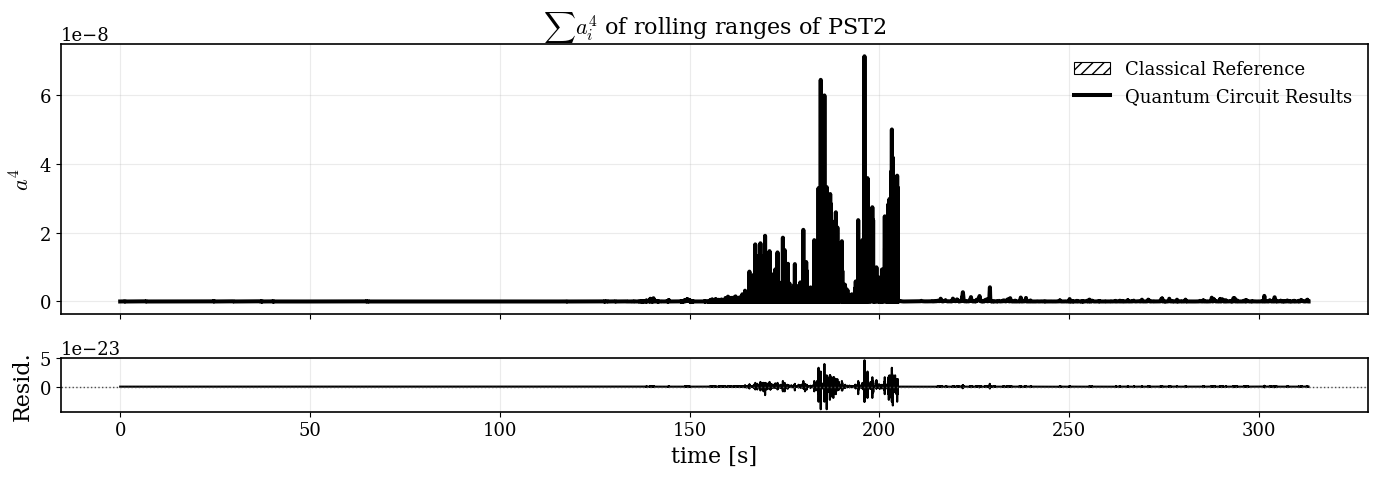

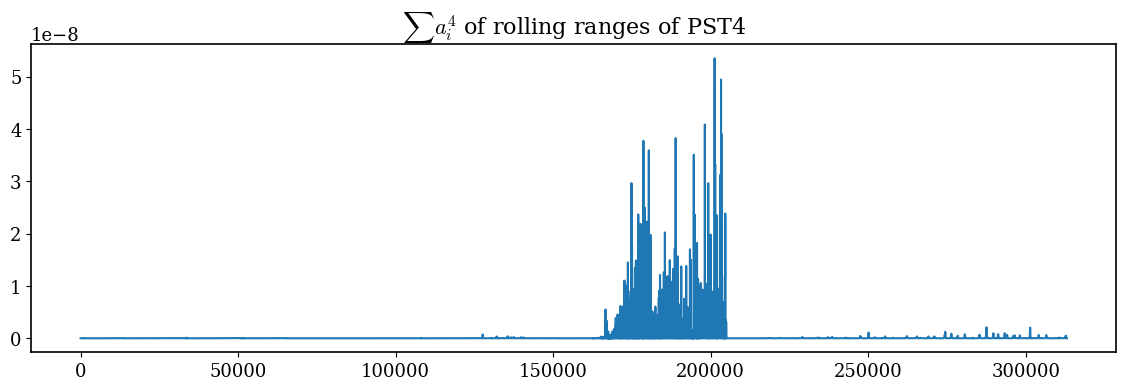

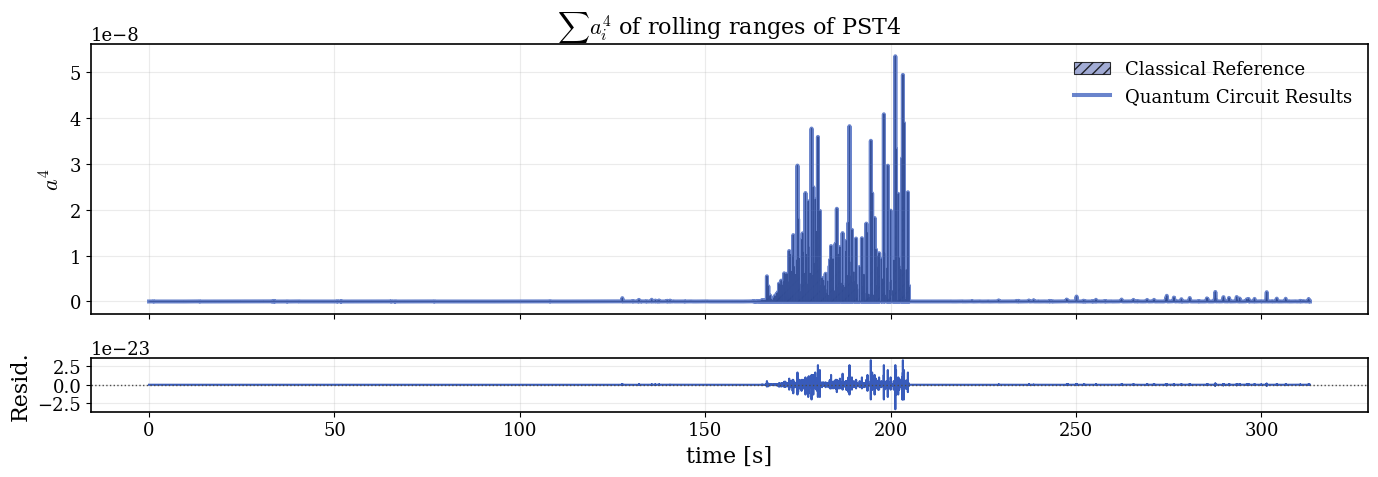

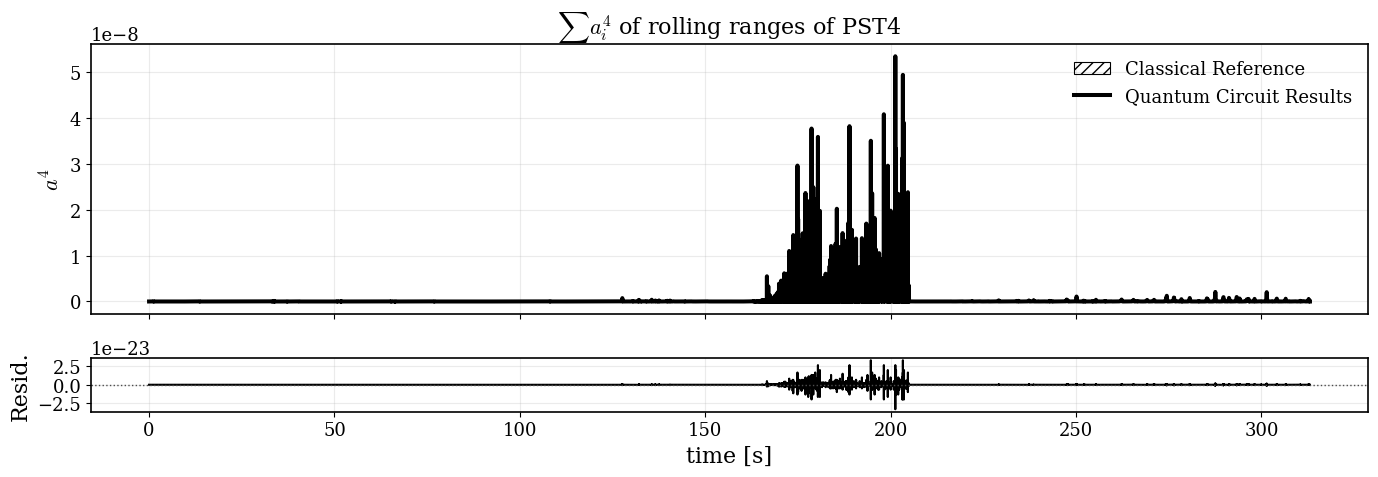

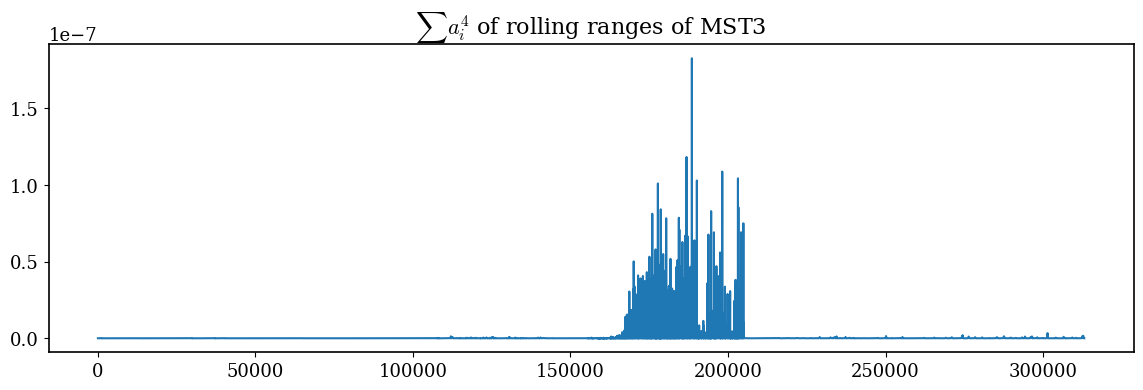

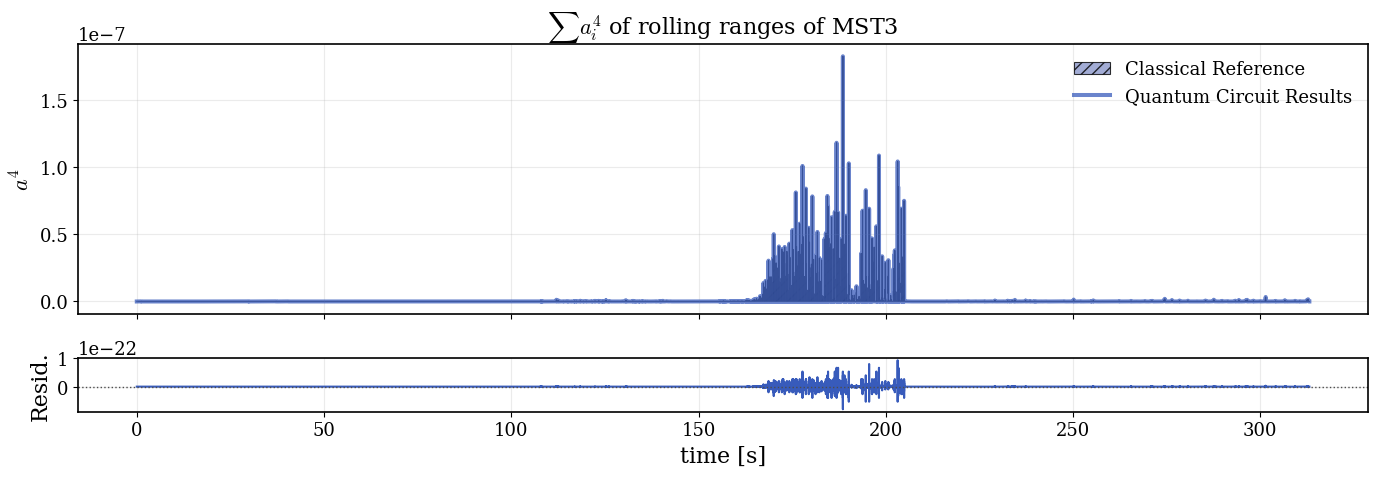

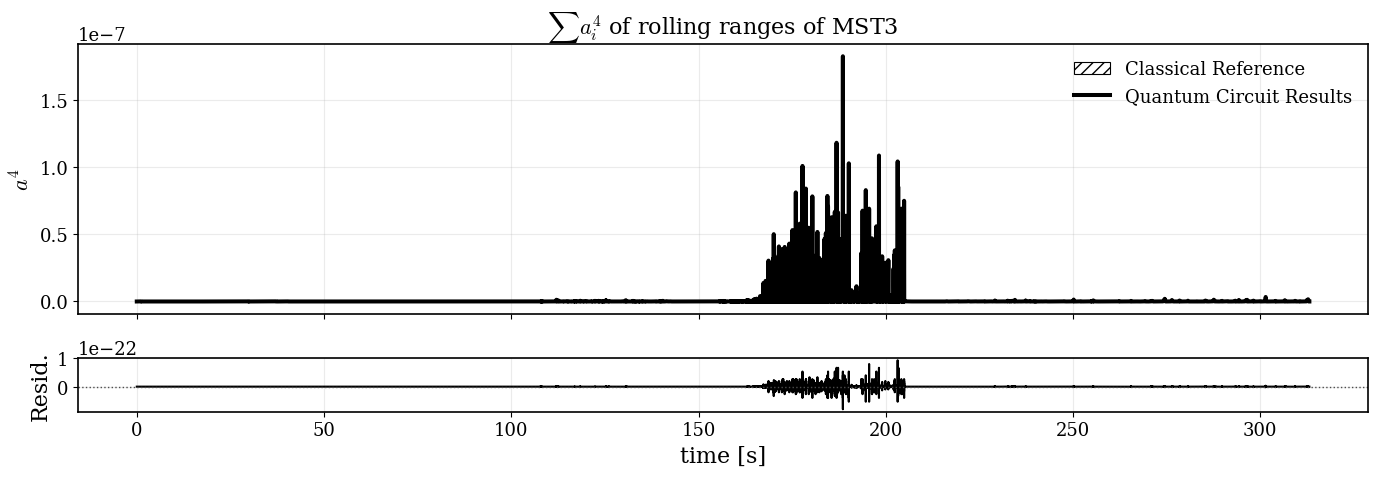

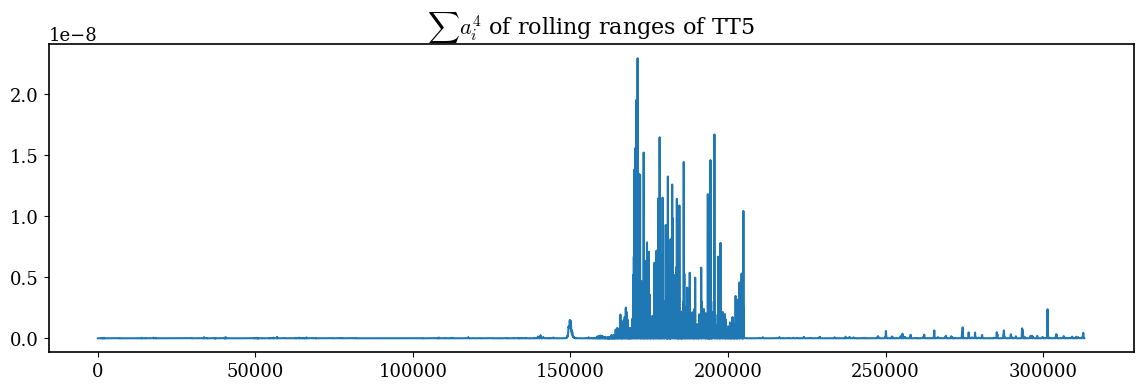

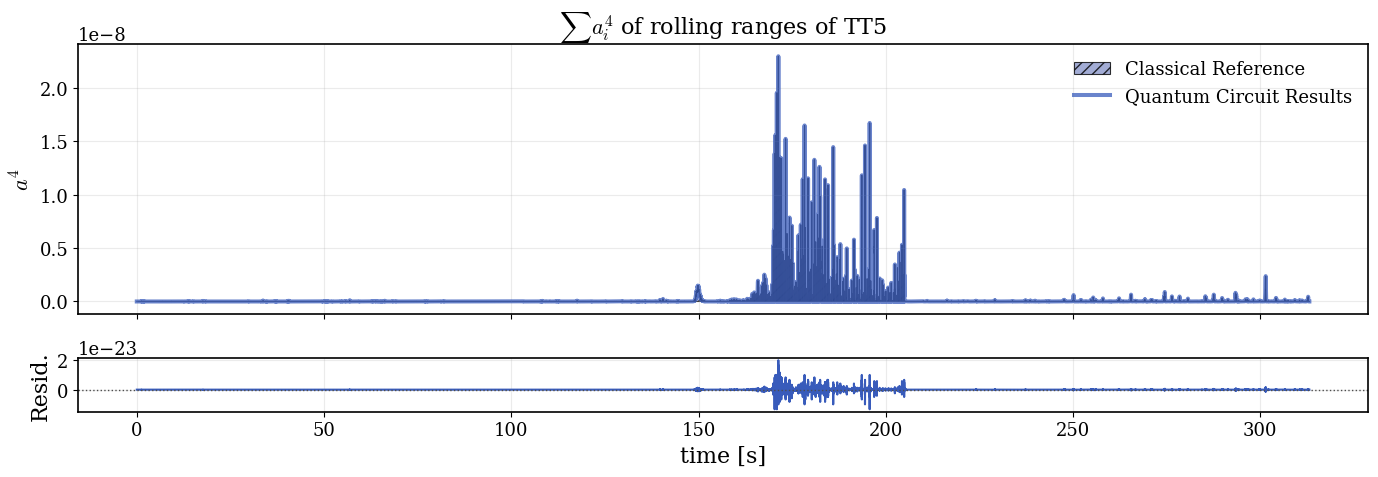

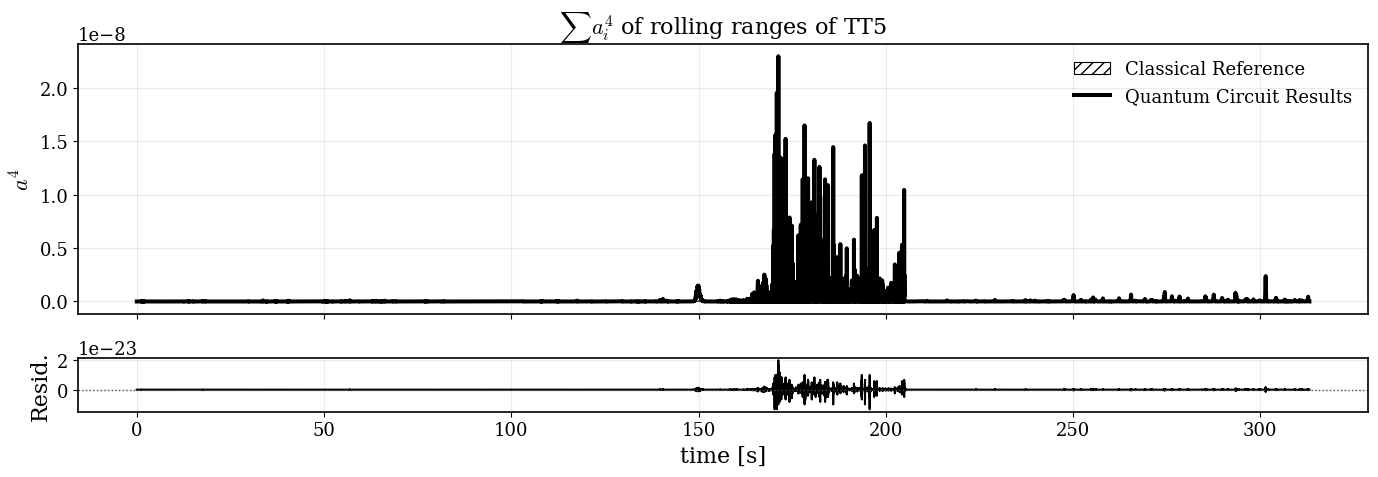

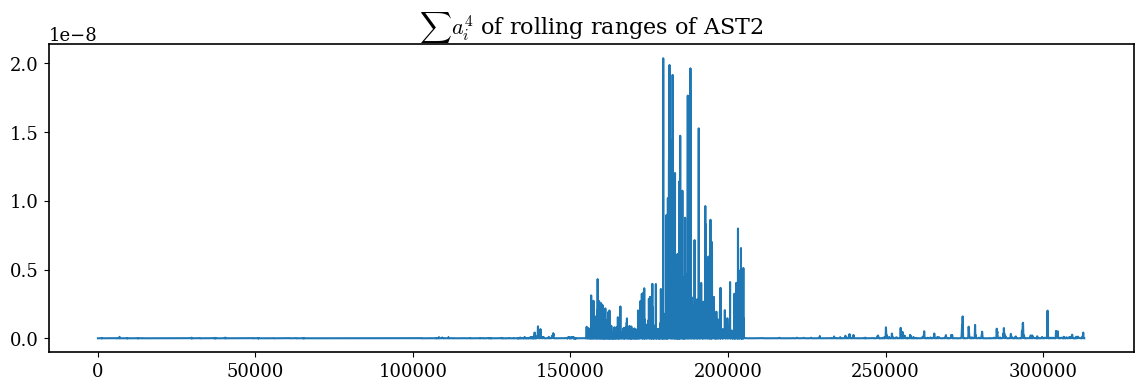

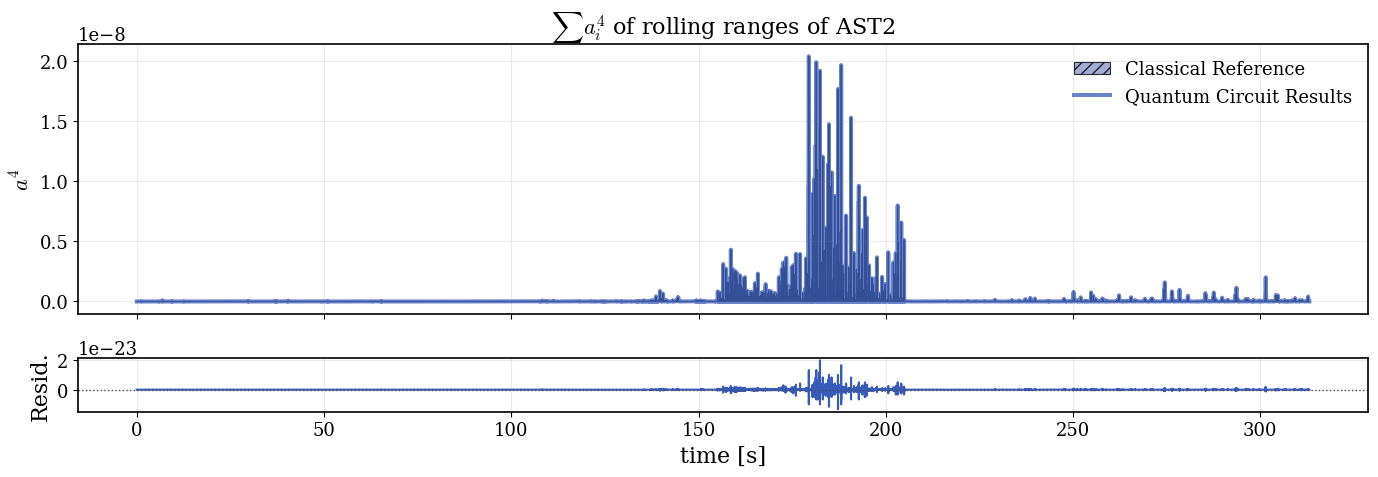

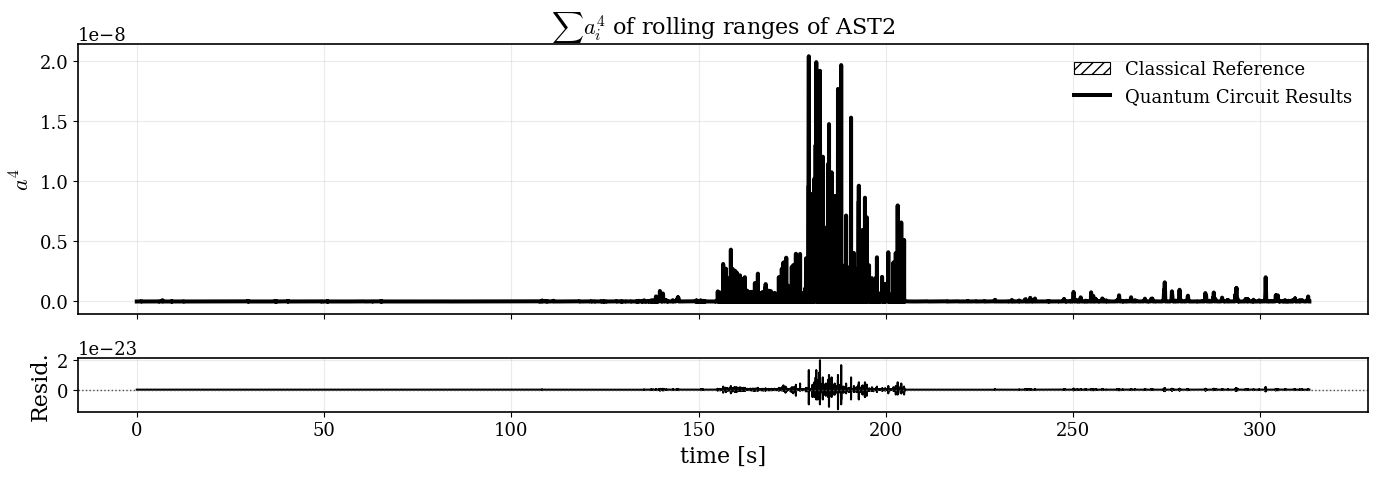

In [248]:
for i in tqdm(range(len(channel_names))):
    full_a4(i)